Dokonczyc RNN
UNET testowac na innych zbiorach
Transformer
Podstawowe eksperymenty z RSA
Runtime - jak rozwiazac to zagadnienie???
Zestawienie porównania wyników modeli
Latex - zacząć pisać od końca
1. Przeglad aktualnych rozwiazan
2. Implementacja
3. Rezultaty

# RNN for R-peak detection using the pytorch library

In [1]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from customLib.vis import *
from customLib.preprocess import *
from customLib.peak_detection import *
from customLib.dataset import read_dataset
from customLib.config import fantasia_path, mitbih_path
from models.models import LSTM
from customLib.print_model_parameters import print_model_parameters
from customLib.metrics import print_metrics
from torch.utils.data import DataLoader
from models.datasets import ECGDataset
from tqdm import tqdm
from customLib.peak_detection import correct_prediction_according_to_aami
# from torchsummary import summary

In [5]:
LSTM_HIDDEN_SIZE = 32
EPOCHS = 50
BATCH_SIZE = 100
LR = 1e-2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# laod and preprocess dataset
# x, y = load_physionet_ecgs(path=mitbih_path, annotation_file_extension="atr", force_new=True, window_in_seconds=10, expand=False, denoise=True)

In [ ]:
path = mitbih_path + "\\dataset\\raw"
# x_train, y_train, x_test, y_test, x_val, y_val = split_dataset(path=mitbih_path, x=x, y=y, shuffle=False, split_ratio=0.8, is_validation_set=True)
x_train, y_train, x_test, y_test, x_val, y_val = read_dataset(path=path, is_validation_set=True)

x_train = np.expand_dims(x_train, 2)
y_train = np.expand_dims(y_train, 2)

x_test = np.expand_dims(x_test, 2)
y_test = np.expand_dims(y_test, 2)

x_val = np.expand_dims(x_val, 2)
y_val = np.expand_dims(y_val, 2)

In [ ]:
num_pos = np.sum(y_train[0])
num_neg = len(y_train[0]) - num_pos
pos_weight = int(num_neg / num_pos / 5)
pos_weight = torch.tensor([17], dtype=torch.float32).to(device)
print(f"Positive label weight (R-peak): {(pos_weight.item()):.5f}")

Positive label weight (R-peak): 17.00000


In [ ]:
model = LSTM(input_dim=1, hidden_size=LSTM_HIDDEN_SIZE, lr=LR, loss_pos_weight=pos_weight, checkpoint_path="./checkpoints/raw_ecgs/lstm") #input_size == hidden features size (1-lead ECG)
# model.load_state_dict(torch.load(".\\checkpoints\\lstm\\lstm_epoch_50_acc_99.80_f1_0.97.pt"))

Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
print_model_parameters(model)

Layer lstm_1: 8960 parameters
Layer lstm_2: 25088 parameters
Layer dense: 65 parameters
Total params: 34113


====Epoch [1/50]====


 99%|█████████▉| 118/119 [00:22<00:00,  5.95it/s]

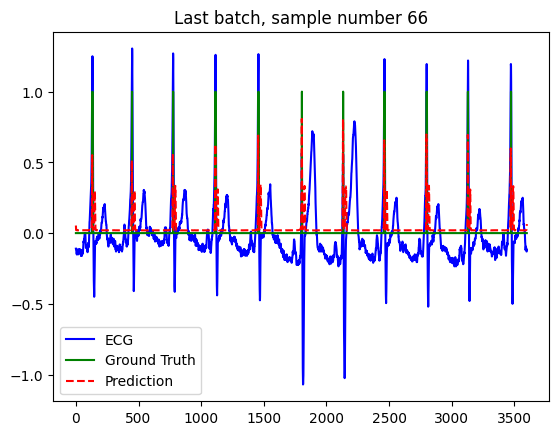

100%|██████████| 119/119 [00:23<00:00,  5.03it/s]


Learning rate:  [0.01]

Train Loss: 0.1942


KeyboardInterrupt: 

In [ ]:
model.train_model(x_train=x_train, y_train=y_train, epochs=EPOCHS, x_val=x_val, y_val=y_val, batch_size=BATCH_SIZE)

In [ ]:
model.test_model(x_test=x_test, y_test=y_test)

100%|██████████| 396/396 [00:03<00:00, 99.33it/s] 



Test Loss: 0.0515
test Weighted Accuracy: 0.99691
test F1 Score: 0.96473
test TPR: 0.99468
test FPR: 0.00086
test TNR: 0.99914
test FNR: 0.00532



In [ ]:
with open("./metrics/lstm.pkl", "wb") as f:
  pickle.dump(model.get_metrics(), f)

In [12]:
from customLib.vis import plot_metrics
import pickle

with open("./metrics/raw/st_res_net.pkl", "rb") as f:
  metrics = pickle.load(f)

In [ ]:
print_metrics(metrics, "all", 49)

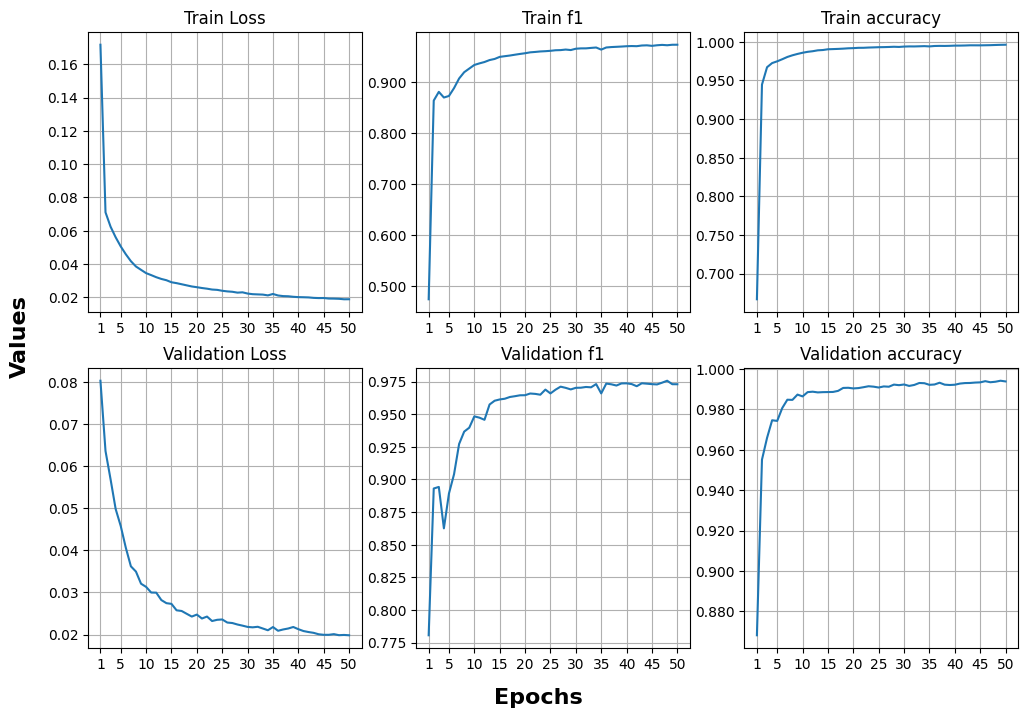

In [13]:
plot_metrics(metrics)

In [ ]:
# load pretrained model
model = LSTM(input_dim=1, hidden_size=LSTM_HIDDEN_SIZE, lr=LR, loss_pos_weight=torch.Tensor([17]))
model.load_state_dict(torch.load(".\\checkpoints\\lstm\\raw_ecgs\\lstm_epoch_49_acc_95.49_f1_0.89.pt"))


Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\patry\AppData\Local\Temp\ipykernel_20200\2336796335.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `to

<All keys matched successfully>

In [ ]:
model.test_model(x_test=x_test, y_test=y_test)

100%|██████████| 396/396 [00:09<00:00, 42.61it/s]



Test Loss: 0.0495
test Weighted Accuracy: 0.95439
test F1 Score: 0.88758
test TPR: 0.90927
test FPR: 0.00049
test TNR: 0.99951
test FNR: 0.09073



### Testing with Fantasia and own dataset, both on preprocessed and raw dataset

In [14]:
pos_weight = torch.Tensor([17]).to(device)

lstm = LSTM(input_dim=1, hidden_size=LSTM_HIDDEN_SIZE, lr=LR, loss_pos_weight=pos_weight)
lstm.load_state_dict(torch.load(".\\checkpoints\\lstm\\lstm_epoch_50_acc_99.71_f1_0.97.pt"))

raw_lstm = LSTM(input_dim=1, hidden_size=LSTM_HIDDEN_SIZE, lr=LR, loss_pos_weight=pos_weight)
raw_lstm.load_state_dict(torch.load(".\\checkpoints\\lstm\\raw_ecgs\\lstm_epoch_49_acc_95.49_f1_0.89.pt"))

Training will be performed with: cuda:0
Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\patry\AppData\Local\Temp\ipykernel_28656\1563145667.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `to

<All keys matched successfully>

In [ ]:
x = np.load(fantasia_path + "\\preprocessed\\downsampled\\x.npy")
y = np.load(fantasia_path + "\\preprocessed\\downsampled\\y.npy")

x_raw = np.load(fantasia_path + "\\preprocessed\\raw\\x.npy")
y_raw = np.load(fantasia_path + "\\preprocessed\\raw\\y.npy")

x_raw =  np.expand_dims(x_raw, 2)
y_raw = np.expand_dims(y_raw, 2)

x = np.expand_dims(x, 2)
y = np.expand_dims(y, 2)

In [15]:
x_aidmed = np.load(".\\aidmed_ecgs\\preprocessed\\x.npy")
y_aidmed = np.load(".\\aidmed_ecgs\\preprocessed\\y.npy")

x_aidmed_raw = np.load(".\\aidmed_ecgs\\raw\\x.npy")
y_aidmed_raw = np.load(".\\aidmed_ecgs\\raw\\\y.npy")

x_aidmed = np.expand_dims(x_aidmed, 2)
y_aidmed = np.expand_dims(y_aidmed, 2)

x_aidmed_raw = np.expand_dims(x_aidmed_raw, 2)
y_aidmed_raw = np.expand_dims(y_aidmed_raw, 2)

<>:5: SyntaxWarning: invalid escape sequence '\y'
<>:5: SyntaxWarning: invalid escape sequence '\y'
C:\Users\patry\AppData\Local\Temp\ipykernel_28656\3332623104.py:5: SyntaxWarning: invalid escape sequence '\y'
  y_aidmed_raw = np.load(".\\aidmed_ecgs\\raw\\\y.npy")


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def test_model(model, x_test, y_test, plot=False):
    test_dataset = ECGDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    running_loss = 0.0
    num_r_peaks = 0.0
    num_correct = 0.0

    all_outputs = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for i, (x_test, y_test) in tqdm(enumerate(test_loader), total=len(test_loader)):
            x, y = x_test.to(device), y_test.to(device)
            outputs = model(x)

            loss = model.criterion(outputs, y)
            running_loss += loss.item()

            outputs = torch.sigmoid(outputs)

            outputs = outputs.cpu().detach().numpy()
            y = y.cpu().detach().numpy()

            num_r_peaks += np.where(y == 1)[0].shape[0]
            num_correct += np.where((outputs > 0.5) & (y == 1))[0].shape[0]

            all_outputs.extend(outputs.flatten())
            all_labels.extend(y.flatten())

            ecg = x[0].cpu().detach().numpy().flatten()
            gt = y[0].flatten()
            pred_raw = outputs[0].flatten()

            pred = (pred_raw > 0.5).astype(np.int32)

            corrected_r_peaks = correct_prediction_according_to_aami(y_true=gt, y_pred=pred, sampling_rate=ecg.shape[0] / 10)

            correct_r_peaks = np.where((corrected_r_peaks == 1) & (gt == 1))[0]
            false_positives = np.where((corrected_r_peaks == 1) & (gt == 0))[0]
            false_negatives = np.where((corrected_r_peaks == 0) & (gt == 1))[0]

            if (len(false_positives) > 0 or len(false_negatives) > 0) and plot == True:
                gt_line = Line2D([0], [0], color='orange', label='Ground Truth', linestyle='-')
                prediction_line = Line2D([0], [0], color='blue', label='Prediction', linestyle='-')
                correct_line = Line2D([0], [0], color='green', label='Correct line', linestyle='-')
                error_fp = Line2D([0], [0], color='crimson', label='FP', linestyle='-')
                error_fn = Line2D([0], [0], color='darkviolet', label='FN', linestyle='-')

                fig, axs = plt.subplots(nrows=3, sharex=True)
                ax = axs[0]
                ax.plot(ecg)
                ax.legend(["ECG"])
                ax.grid()

                ax = axs[1]
                ax.plot(pred)
                ax.plot(gt)
                ax.grid()
                ax.legend(handles=[gt_line, prediction_line])

                #ax = axs[2]
                #ax.plot(pred_raw)
                #ax.legend(["Raw prediction"])
                #ax.grid()

                ax = axs[2]
                ax.plot(gt, 'g-')
                ax.grid()
                ax.legend(handles=[correct_line, error_fp, error_fn])

                for correct in correct_r_peaks:
                    ax.vlines(correct, 0, 1, color='g', linestyle='-')
                for fp in false_positives:
                    ax.vlines(fp, 0, 1, color='crimson', linestyle='-', linewidth=2)
                for fn in false_negatives:
                    ax.vlines(fn, 0, 1, color='darkviolet', linestyle='-', linewidth=2)

                fig.text(0.5, 0.02, 'Samples', ha='center', weight='semibold', fontsize="16")
                fig.text(0.02, 0.5, 'Values', va='center', rotation='vertical', weight='semibold', fontsize="16")

                fig.set_size_inches(6,6)
                plt.show()
            
    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    y_pred_binary = (all_outputs > 0.5).astype(int)
    test_loss = running_loss / len(test_loader)
    print(f"\nTest Loss: {test_loss:.4f}")
    model.calculate_metrics(test_loss, all_labels, y_pred_binary, "test")

In [ ]:
test_model(lstm, x_test=x, y_test=y, plot=True)

In [ ]:
test_model(raw_lstm, x_test=x_raw, y_test=y_raw, plot=True)

### test with own ecgs

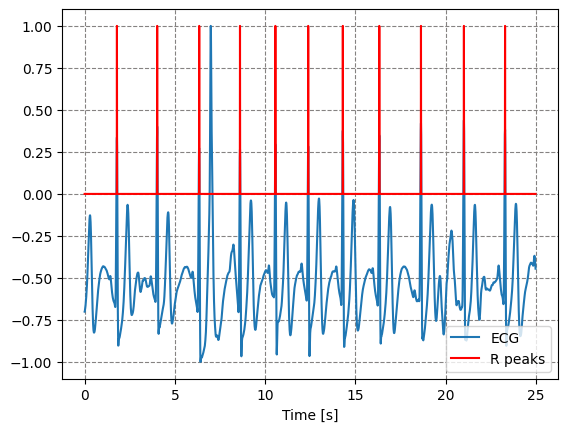

In [43]:
test_x = x_aidmed[37]
test_y = y_aidmed[37]
plot_ecg(test_x, test_y)

  7%|▋         | 34/462 [00:00<00:09, 45.28it/s]

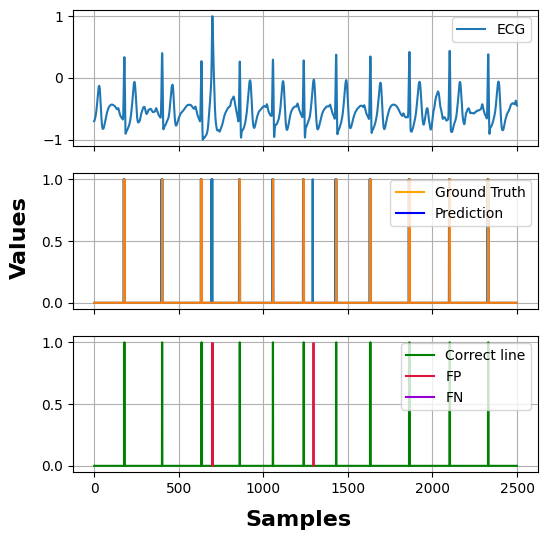

100%|██████████| 462/462 [00:09<00:00, 46.94it/s]



Test Loss: 0.0412
test Weighted Accuracy: 0.99892
test F1 Score: 0.97715
test TPR: 0.99809
test FPR: 0.00025
test TNR: 0.99975
test FNR: 0.00191



In [11]:
test_model(lstm, x_aidmed, y_aidmed, True)

  0%|          | 0/462 [00:00<?, ?it/s]

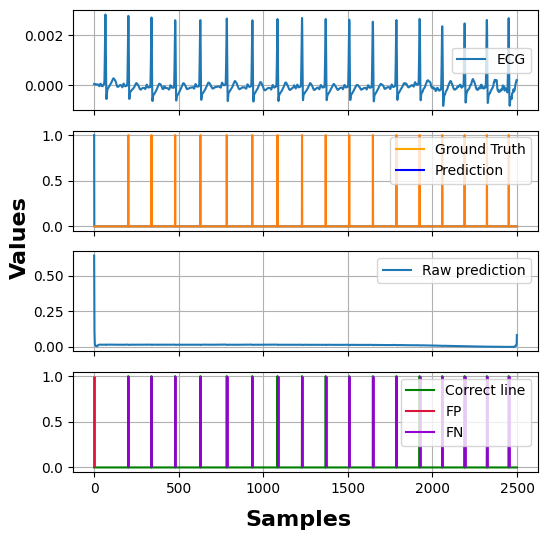

  0%|          | 1/462 [00:00<04:02,  1.90it/s]

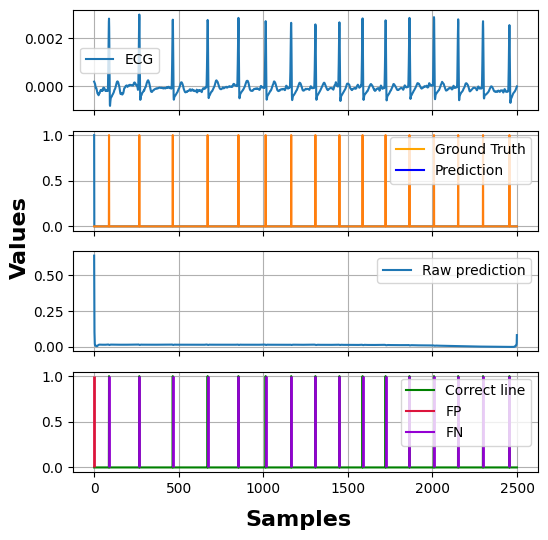

  0%|          | 2/462 [00:01<03:56,  1.95it/s]

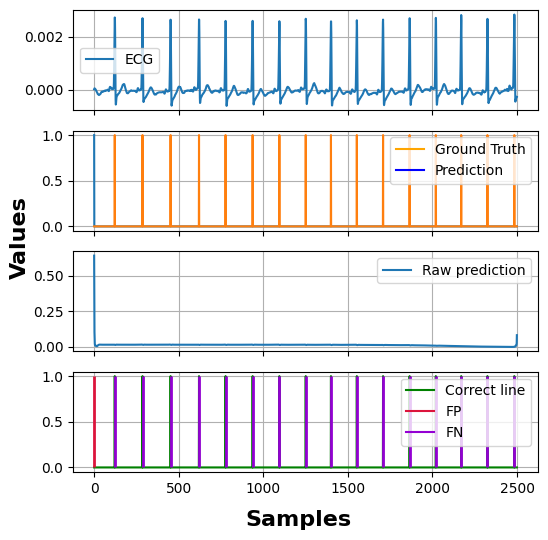

  1%|          | 3/462 [00:01<03:52,  1.97it/s]

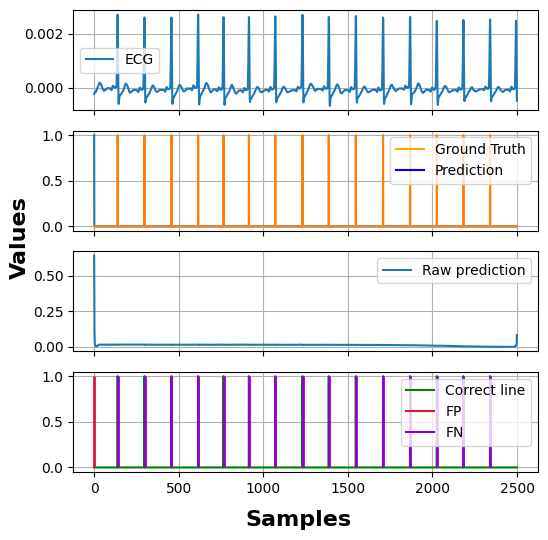

  1%|          | 4/462 [00:02<03:52,  1.97it/s]

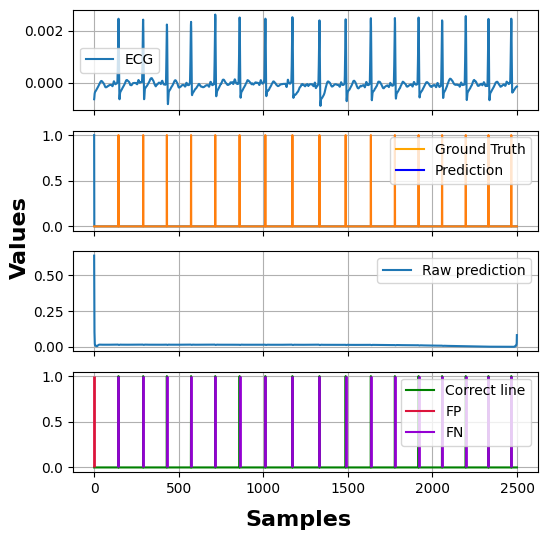

  1%|          | 5/462 [00:02<03:55,  1.94it/s]

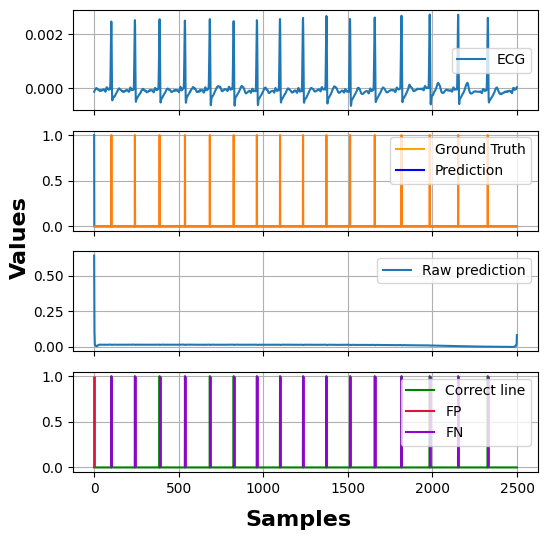

  1%|▏         | 6/462 [00:03<04:00,  1.90it/s]

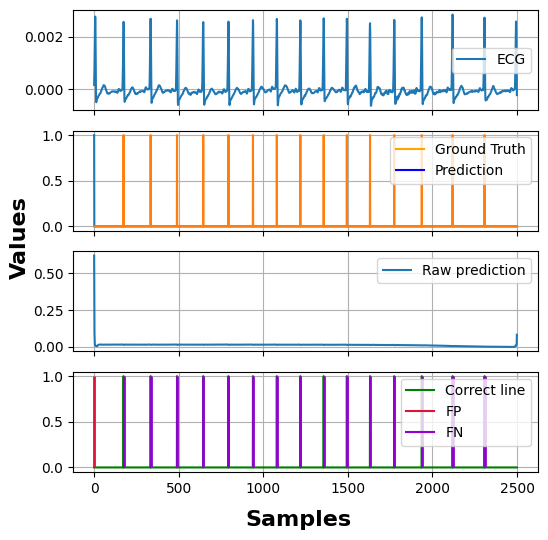

  2%|▏         | 7/462 [00:04<04:53,  1.55it/s]

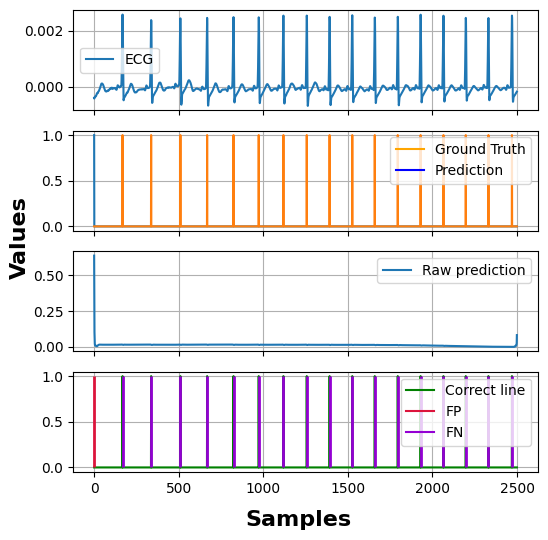

  2%|▏         | 8/462 [00:04<04:34,  1.66it/s]

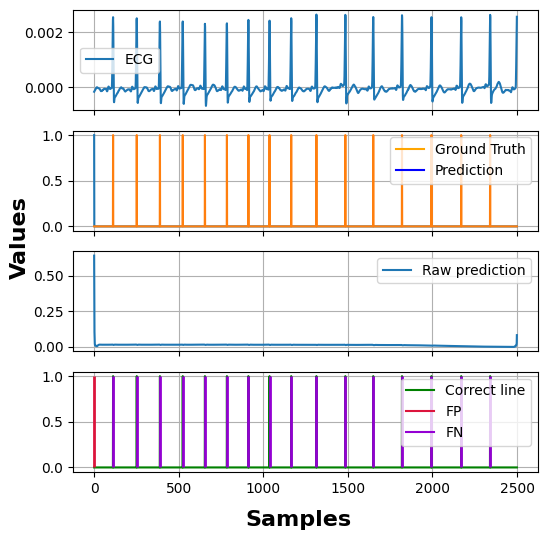

  2%|▏         | 9/462 [00:05<04:25,  1.71it/s]

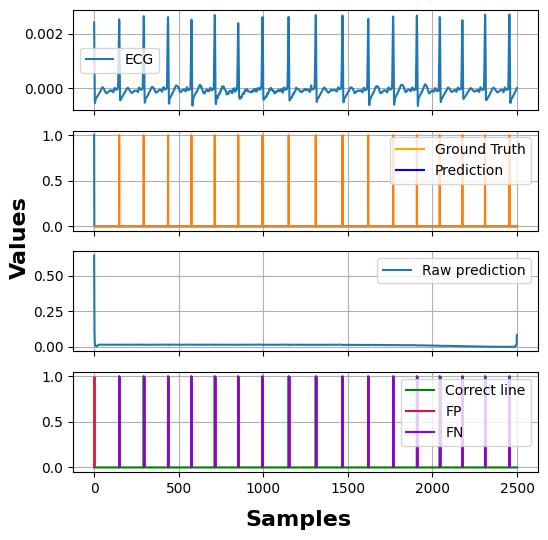

  2%|▏         | 10/462 [00:05<04:22,  1.72it/s]

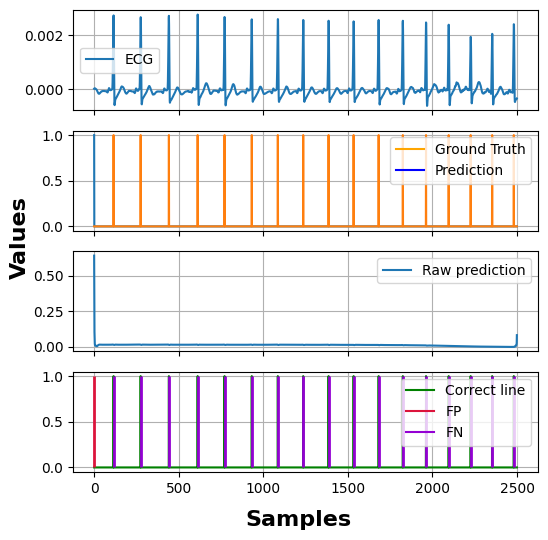

  2%|▏         | 11/462 [00:06<04:07,  1.82it/s]

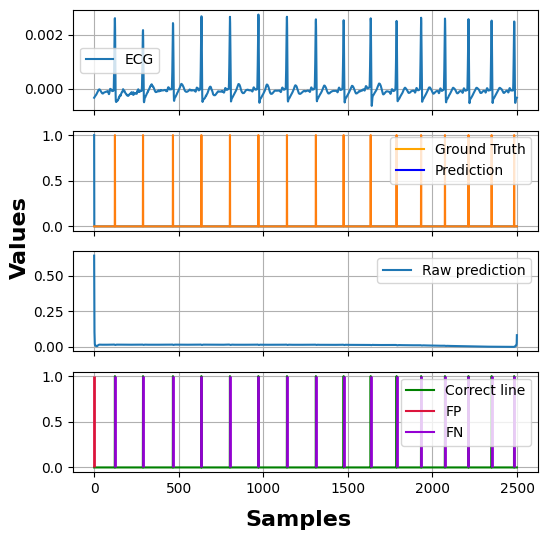

  3%|▎         | 12/462 [00:06<03:58,  1.89it/s]

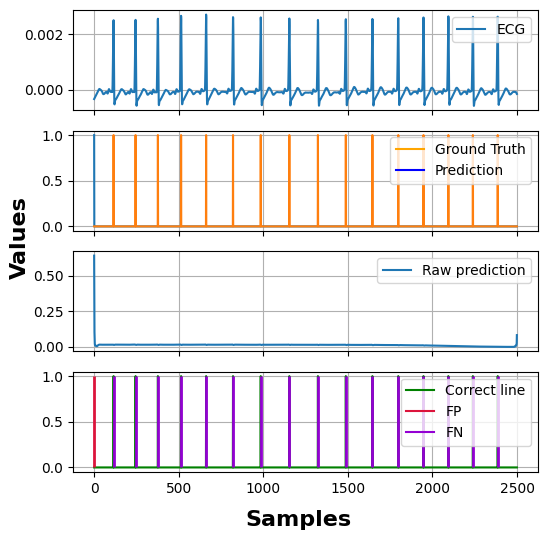

  3%|▎         | 13/462 [00:07<03:51,  1.94it/s]

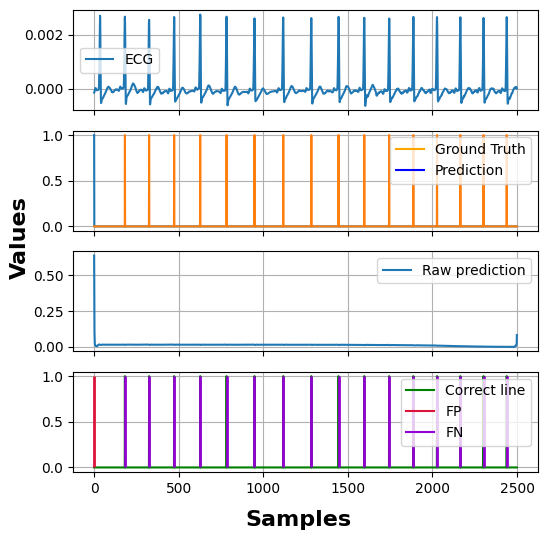

  3%|▎         | 14/462 [00:07<03:46,  1.98it/s]

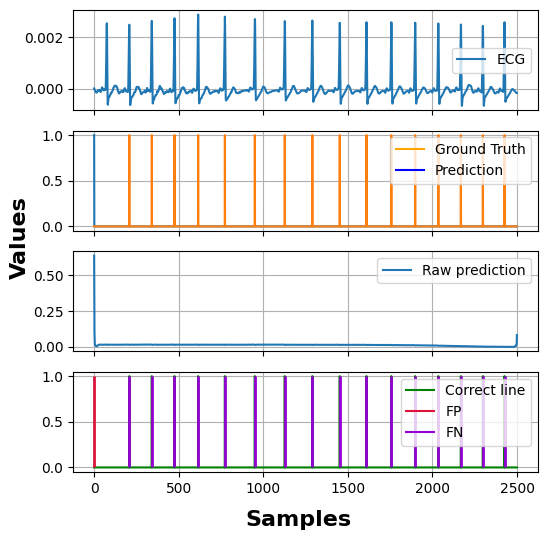

  3%|▎         | 15/462 [00:08<04:10,  1.79it/s]

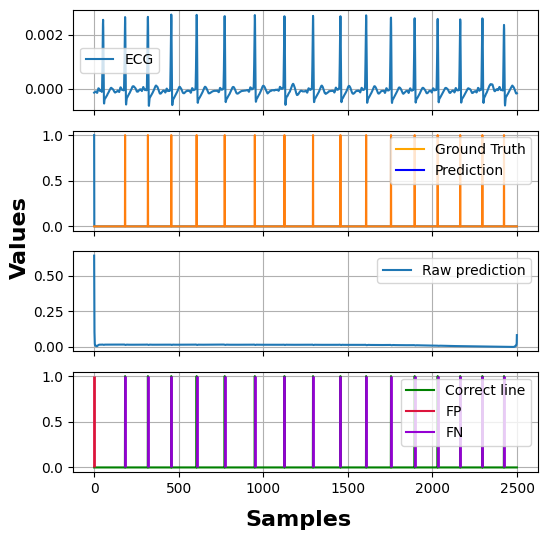

  3%|▎         | 16/462 [00:08<03:58,  1.87it/s]

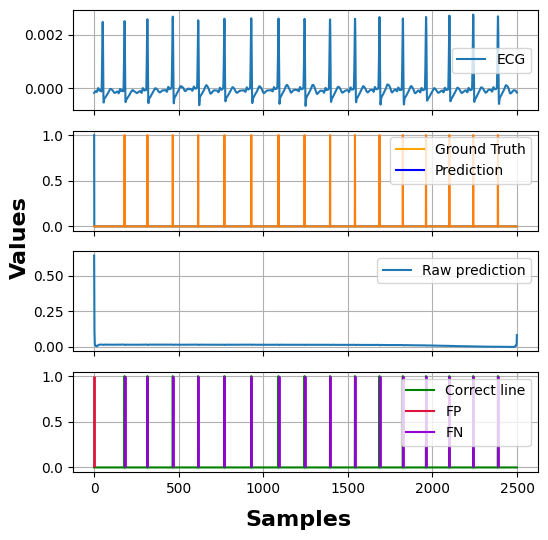

  4%|▎         | 17/462 [00:09<03:50,  1.93it/s]

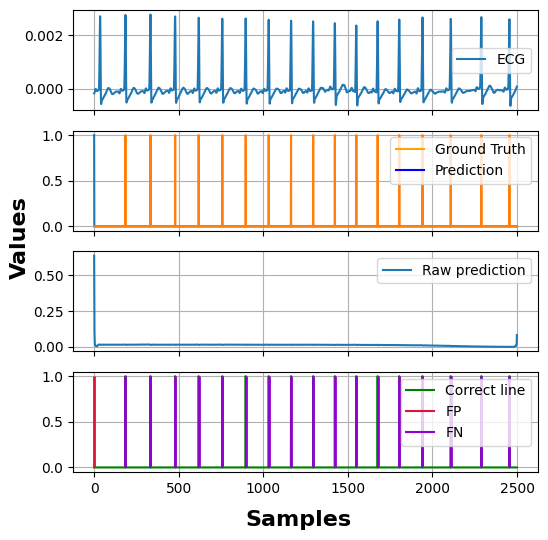

  4%|▍         | 18/462 [00:09<03:44,  1.98it/s]

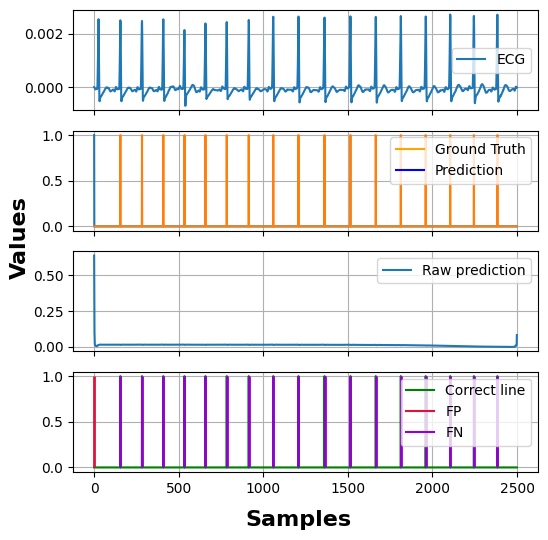

  4%|▍         | 19/462 [00:10<03:39,  2.02it/s]

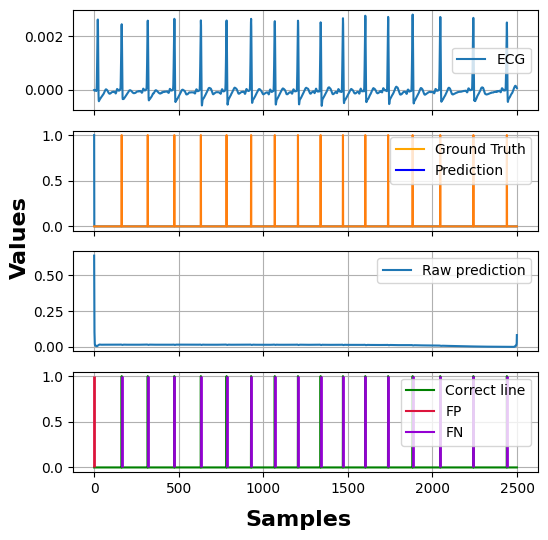

  4%|▍         | 20/462 [00:10<03:39,  2.01it/s]

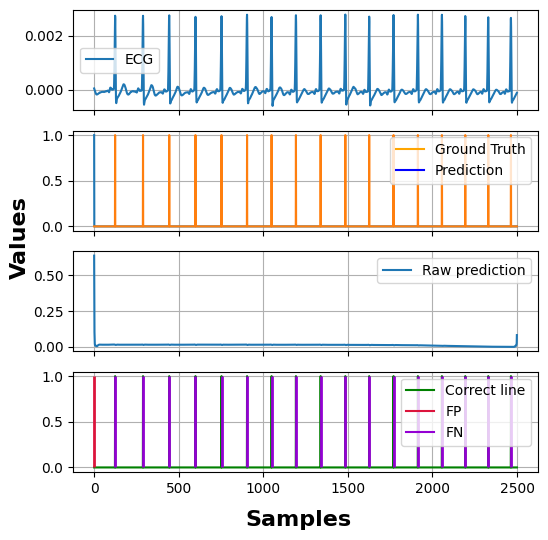

  5%|▍         | 21/462 [00:11<03:36,  2.04it/s]

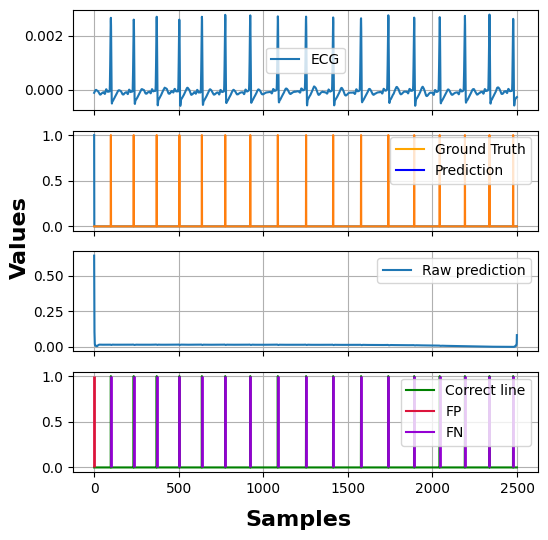

  5%|▍         | 22/462 [00:11<03:36,  2.03it/s]

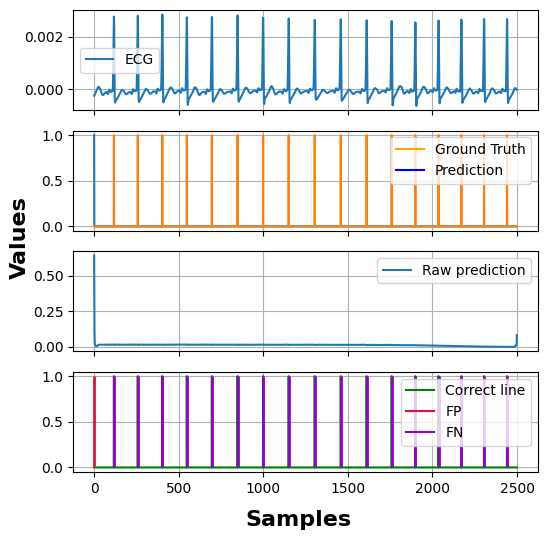

  5%|▍         | 23/462 [00:12<04:05,  1.79it/s]

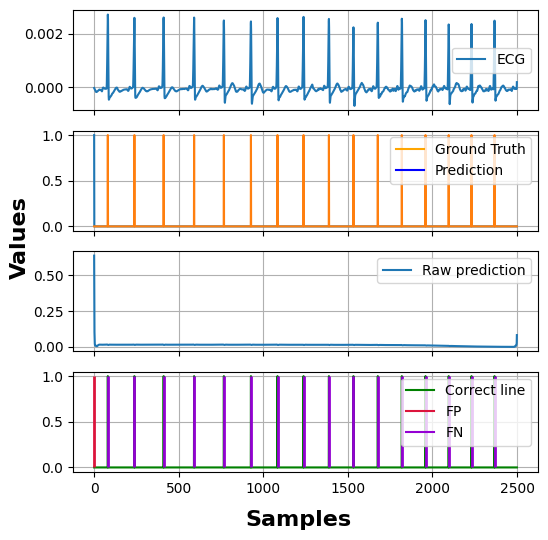

  5%|▌         | 24/462 [00:12<03:52,  1.88it/s]

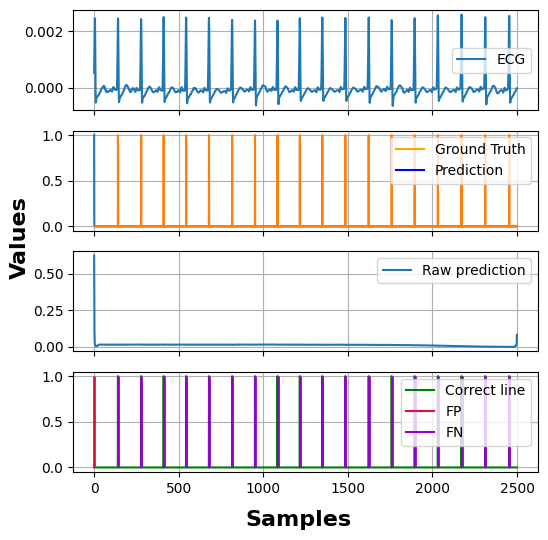

  5%|▌         | 25/462 [00:13<03:47,  1.92it/s]

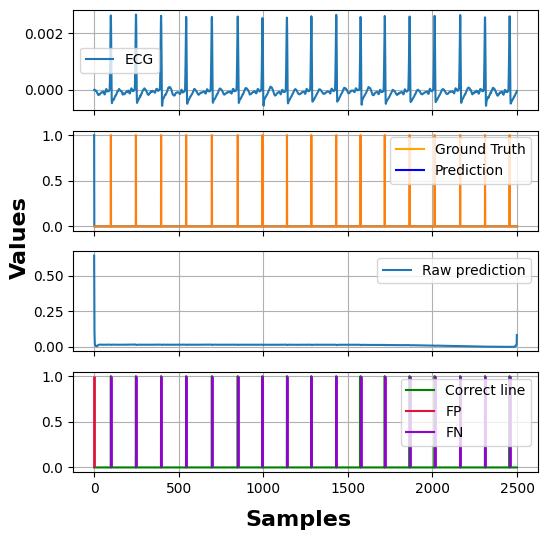

  6%|▌         | 26/462 [00:13<03:40,  1.98it/s]

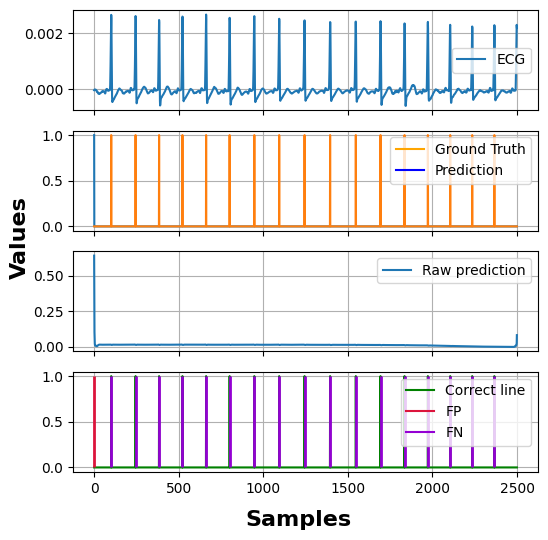

  6%|▌         | 27/462 [00:14<03:35,  2.02it/s]

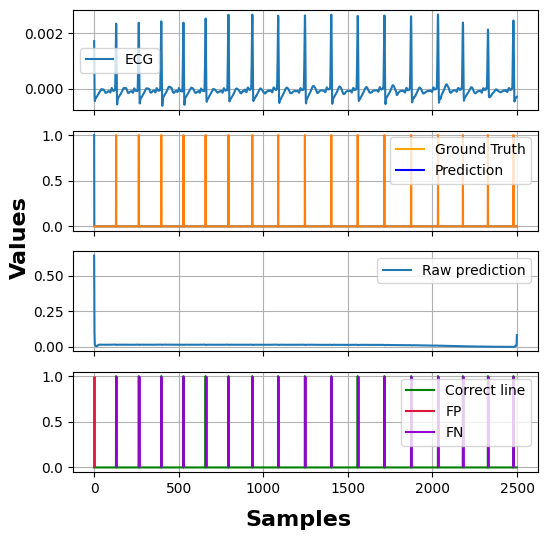

  6%|▌         | 28/462 [00:14<03:34,  2.02it/s]

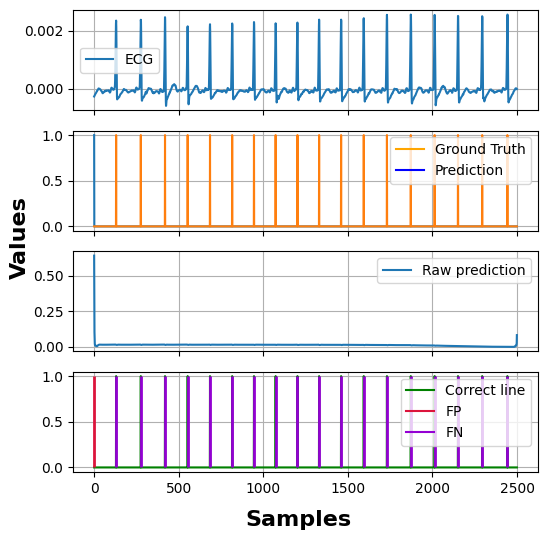

  6%|▋         | 29/462 [00:15<03:31,  2.05it/s]

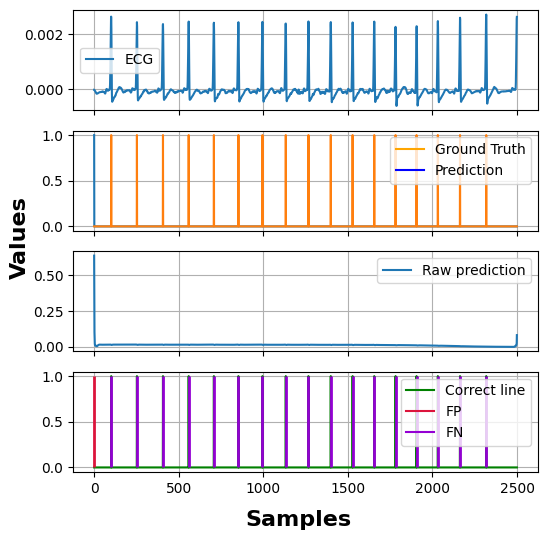

  6%|▋         | 30/462 [00:15<03:31,  2.04it/s]

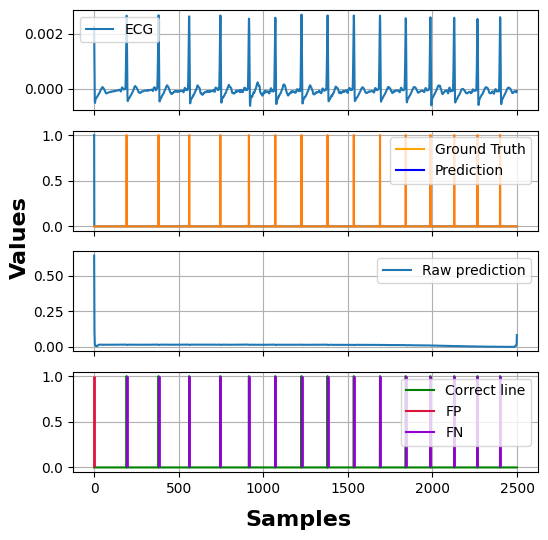

  7%|▋         | 31/462 [00:16<03:57,  1.82it/s]

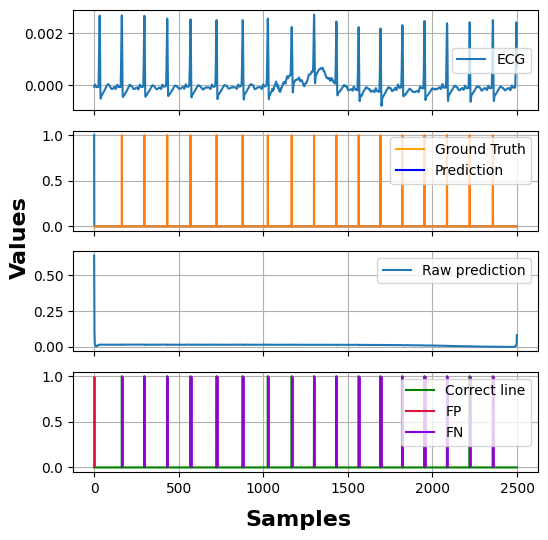

  7%|▋         | 32/462 [00:16<03:46,  1.90it/s]

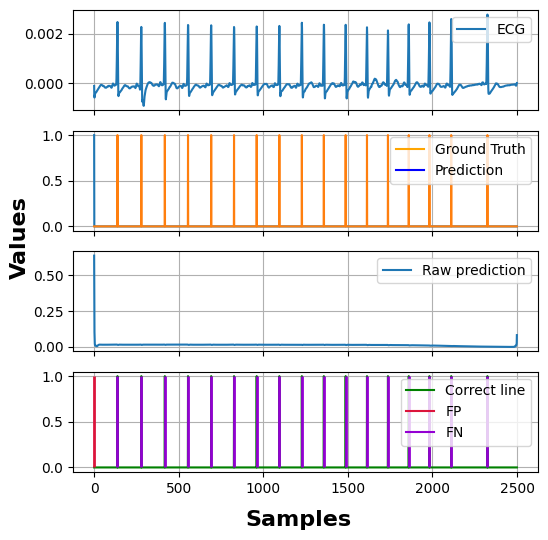

  7%|▋         | 33/462 [00:17<03:39,  1.95it/s]

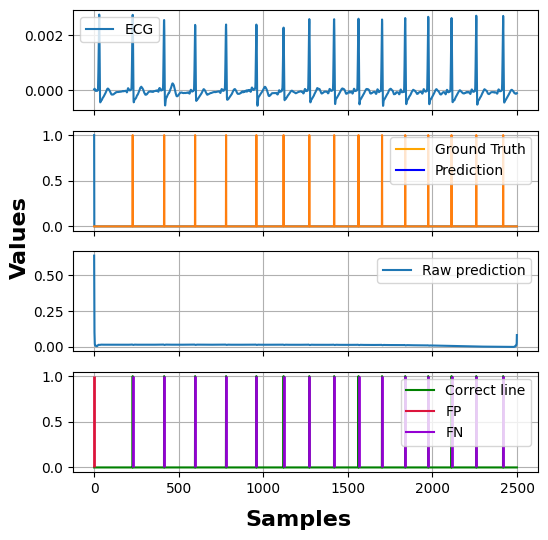

  7%|▋         | 34/462 [00:17<03:34,  1.99it/s]

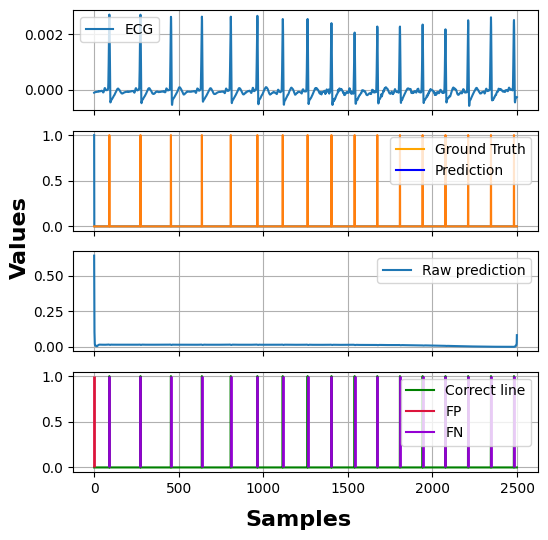

  8%|▊         | 35/462 [00:18<03:33,  2.00it/s]

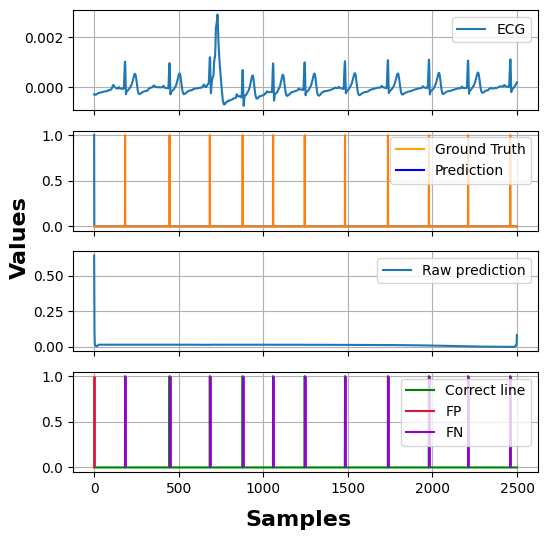

  8%|▊         | 36/462 [00:18<03:32,  2.00it/s]

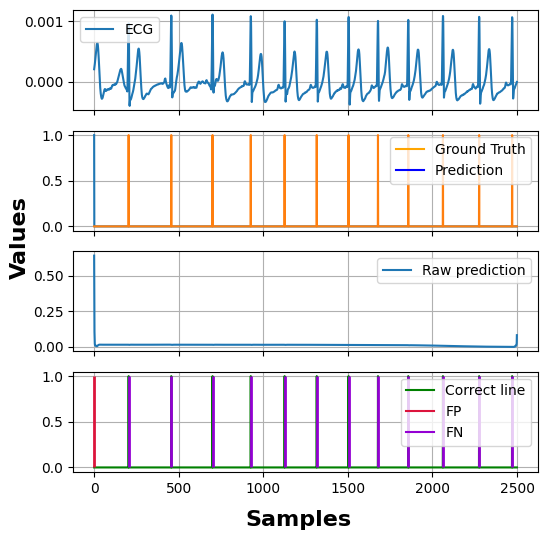

  8%|▊         | 37/462 [00:19<03:27,  2.05it/s]

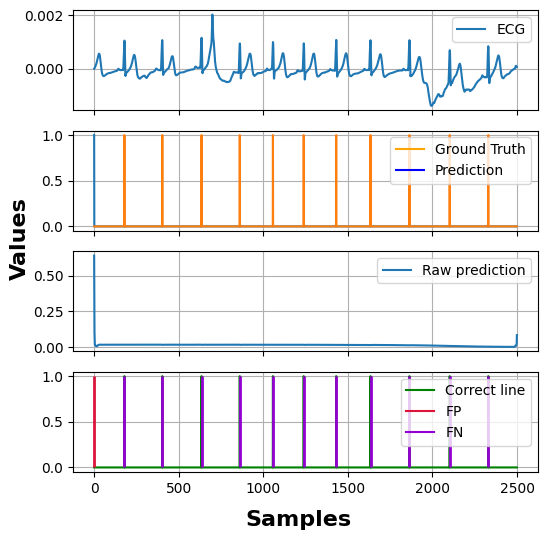

  8%|▊         | 38/462 [00:19<03:25,  2.06it/s]

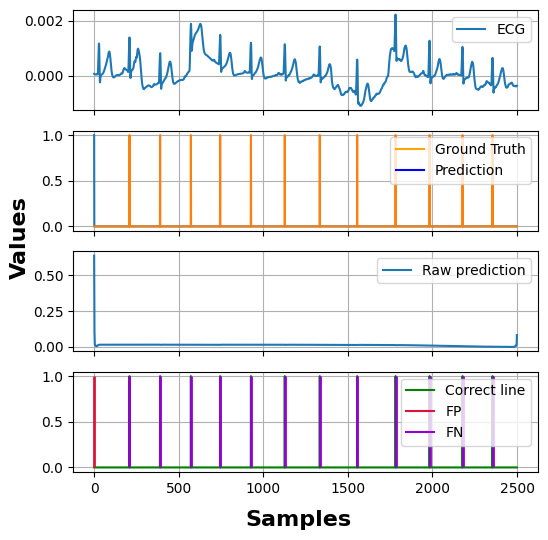

  8%|▊         | 39/462 [00:20<03:26,  2.05it/s]

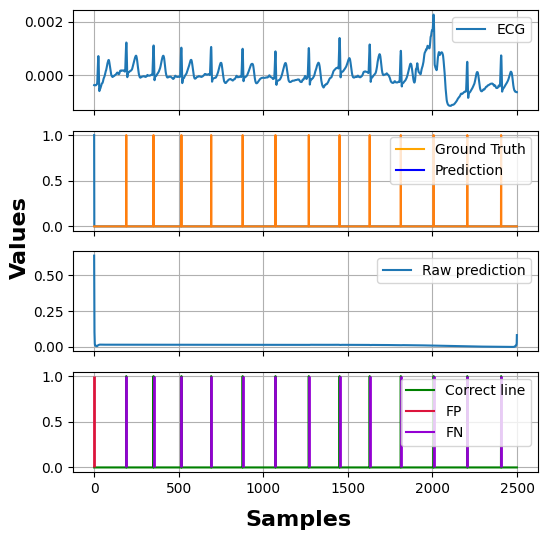

  9%|▊         | 40/462 [00:21<04:00,  1.75it/s]

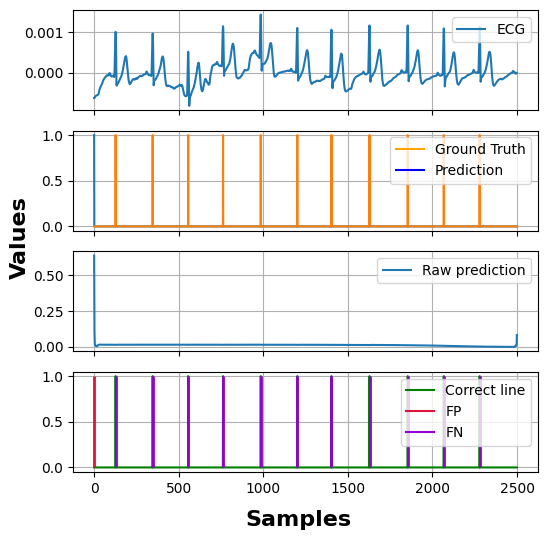

  9%|▉         | 41/462 [00:21<03:55,  1.79it/s]

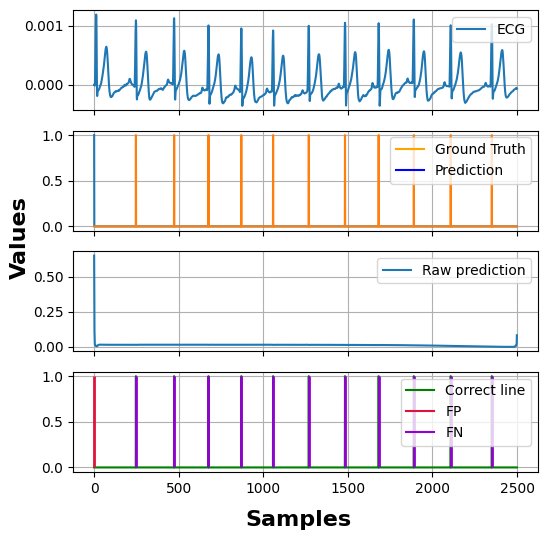

  9%|▉         | 42/462 [00:22<03:45,  1.86it/s]

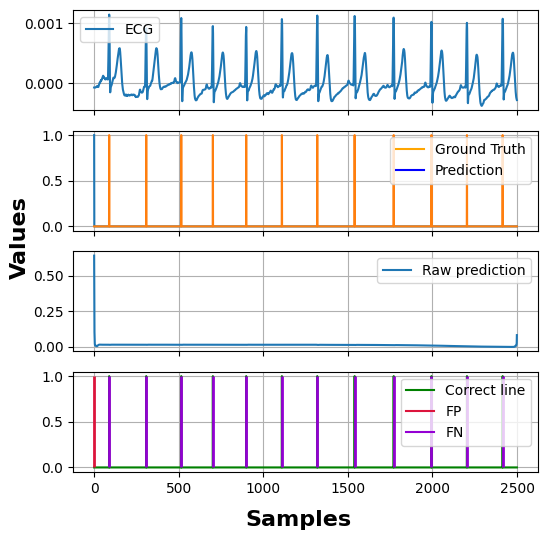

  9%|▉         | 43/462 [00:22<03:36,  1.93it/s]

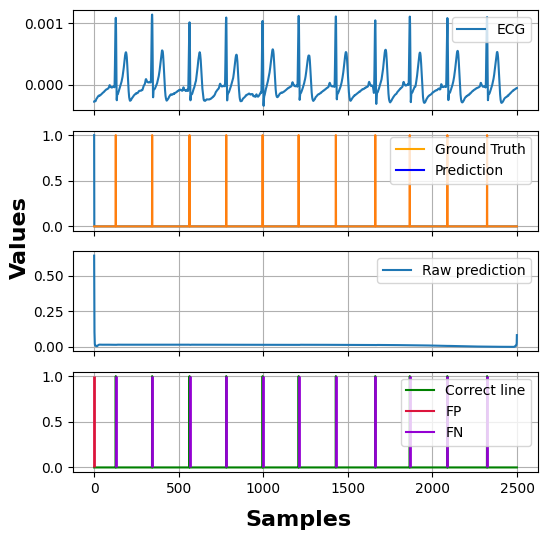

 10%|▉         | 44/462 [00:22<03:31,  1.98it/s]

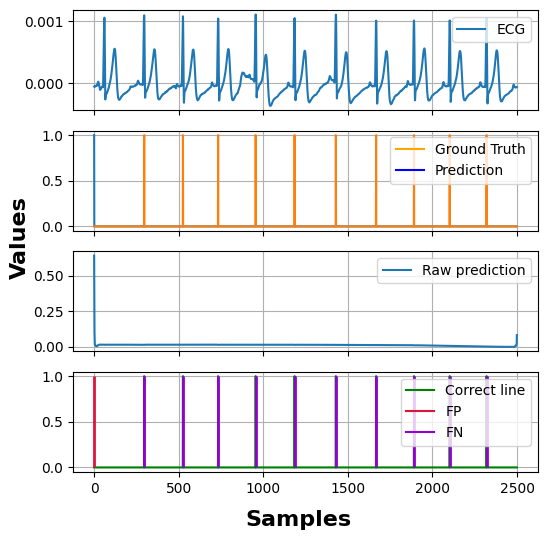

 10%|▉         | 45/462 [00:23<03:27,  2.01it/s]

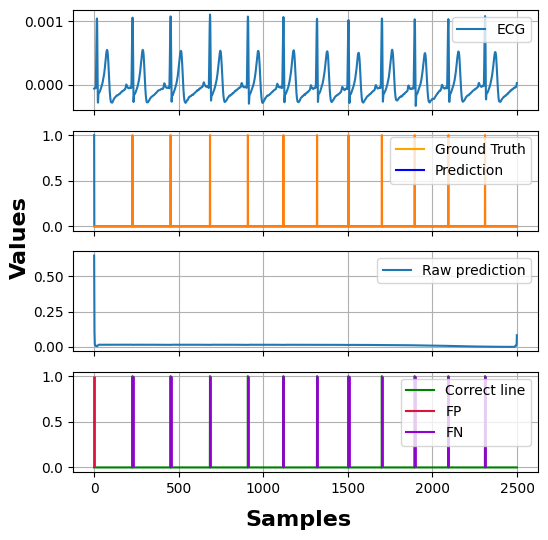

 10%|▉         | 46/462 [00:23<03:27,  2.01it/s]

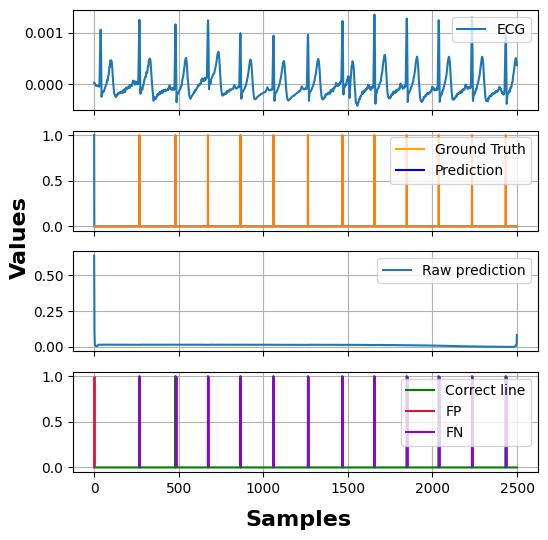

 10%|█         | 47/462 [00:24<03:23,  2.04it/s]

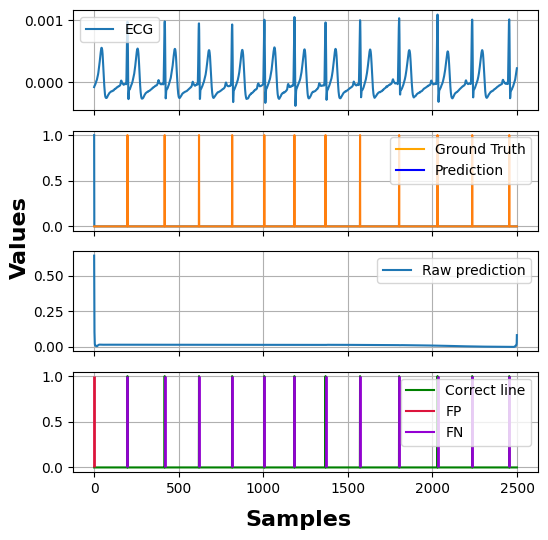

 10%|█         | 48/462 [00:25<03:50,  1.79it/s]

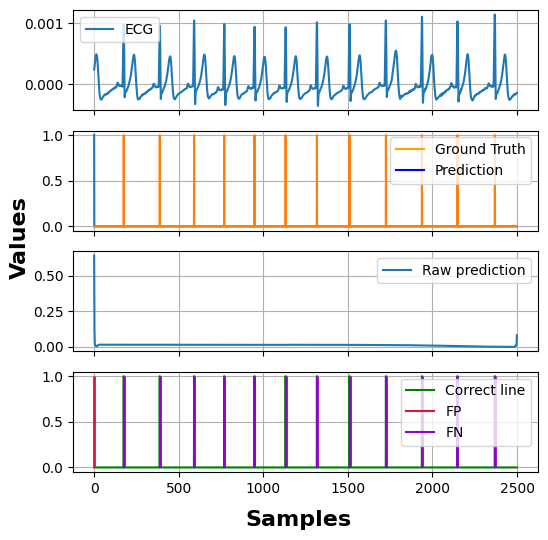

 11%|█         | 49/462 [00:25<03:43,  1.85it/s]

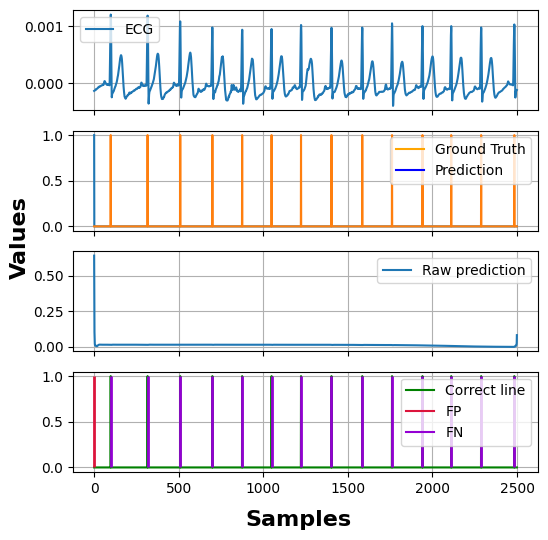

 11%|█         | 50/462 [00:26<03:35,  1.91it/s]

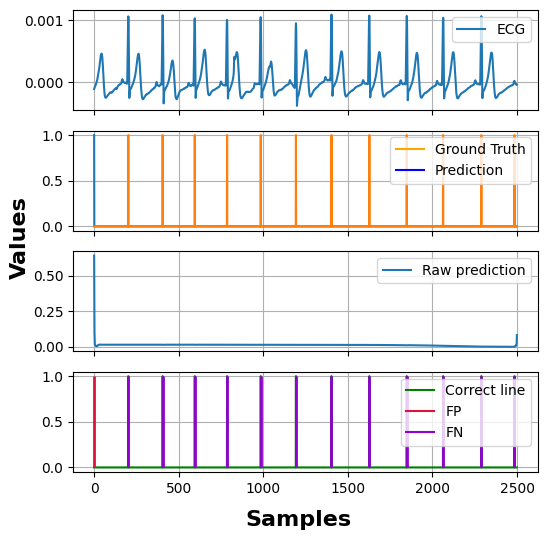

 11%|█         | 51/462 [00:26<03:36,  1.90it/s]

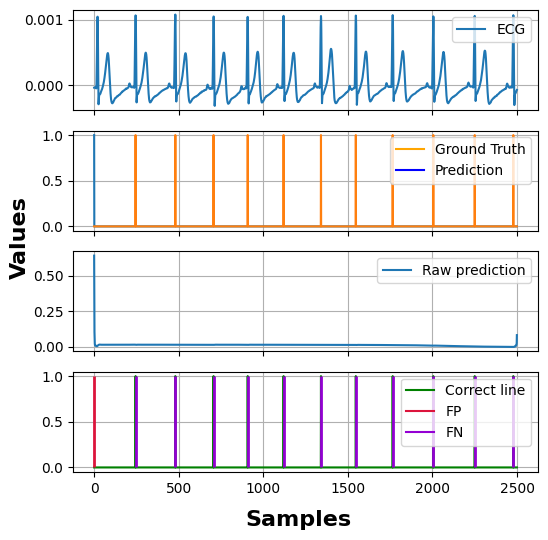

 11%|█▏        | 52/462 [00:27<03:30,  1.95it/s]

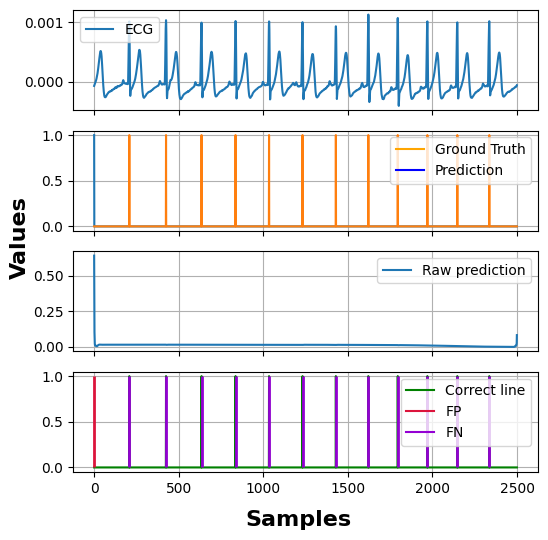

 11%|█▏        | 53/462 [00:27<03:24,  2.00it/s]

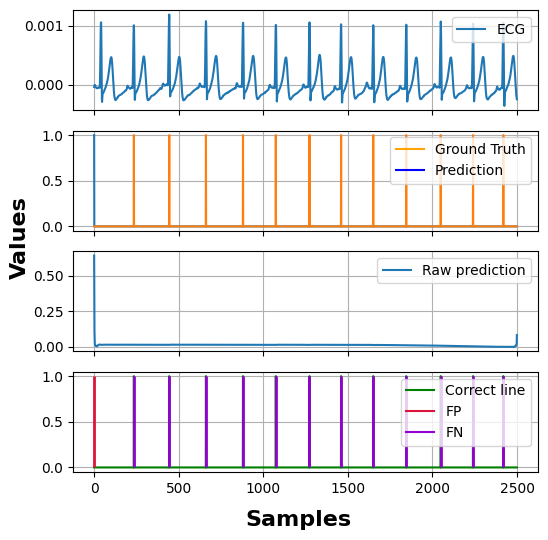

 12%|█▏        | 54/462 [00:28<03:22,  2.02it/s]

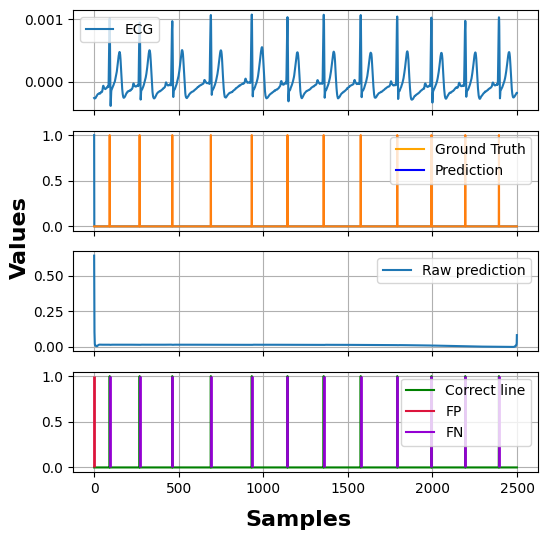

 12%|█▏        | 55/462 [00:28<03:22,  2.01it/s]

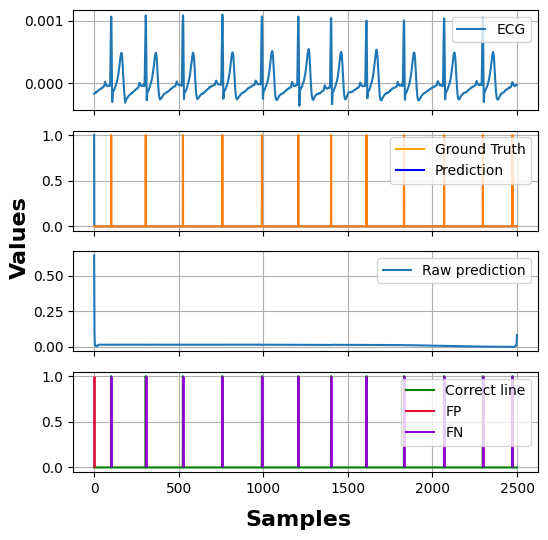

 12%|█▏        | 56/462 [00:29<03:22,  2.00it/s]

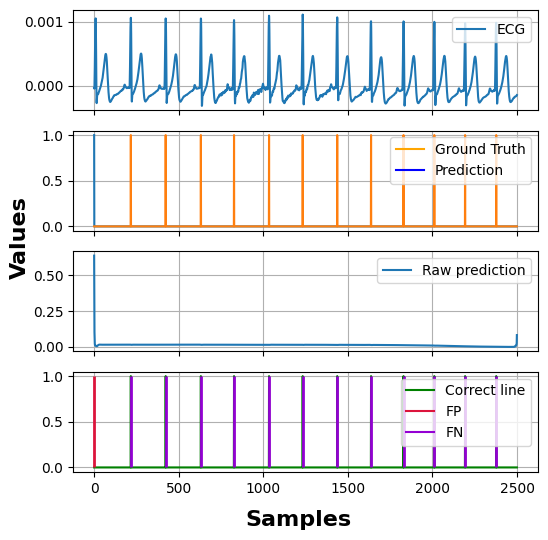

 12%|█▏        | 57/462 [00:29<03:43,  1.81it/s]

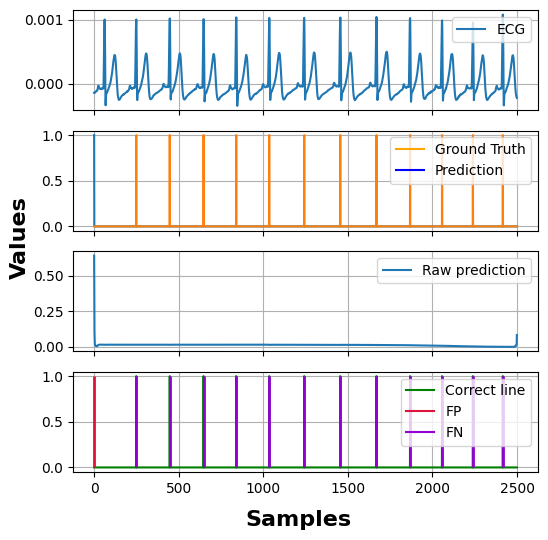

 13%|█▎        | 58/462 [00:30<03:33,  1.89it/s]

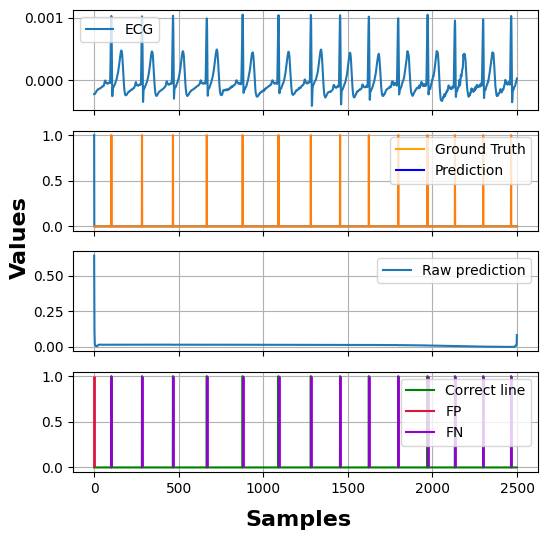

 13%|█▎        | 59/462 [00:30<03:27,  1.94it/s]

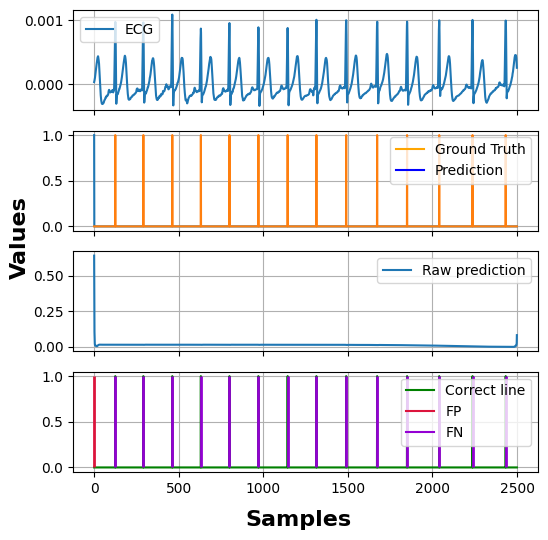

 13%|█▎        | 60/462 [00:31<03:26,  1.95it/s]

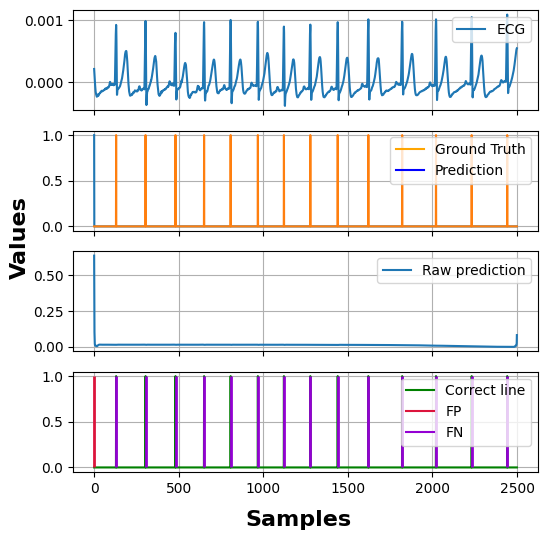

 13%|█▎        | 61/462 [00:31<03:22,  1.98it/s]

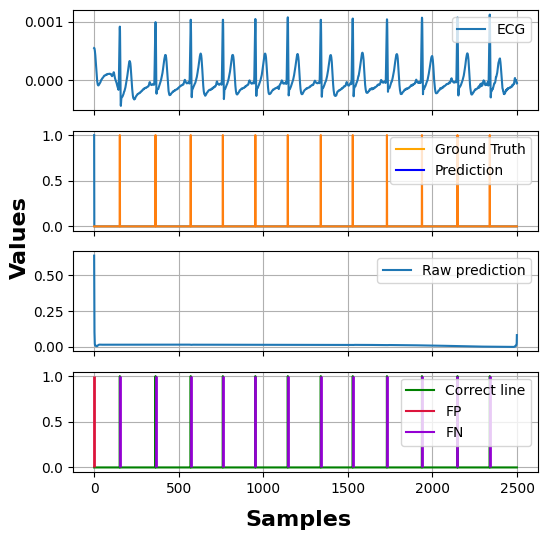

 13%|█▎        | 62/462 [00:32<03:17,  2.02it/s]

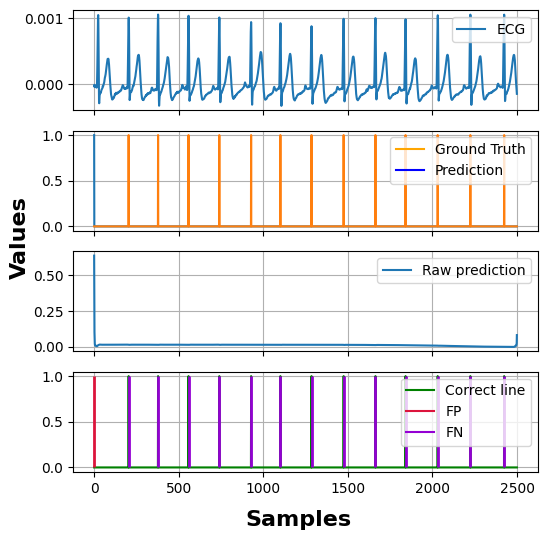

 14%|█▎        | 63/462 [00:32<03:14,  2.05it/s]

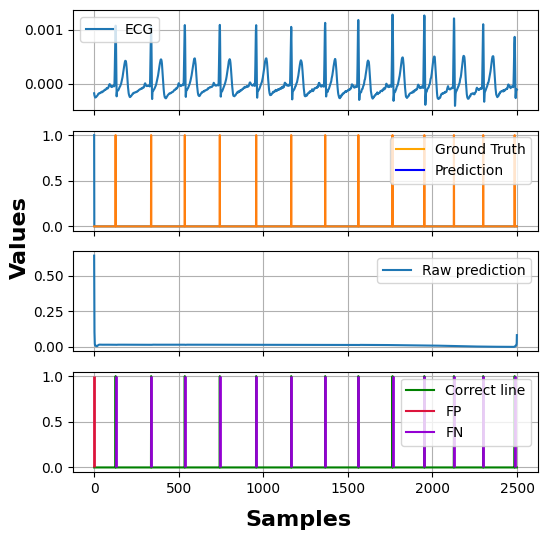

 14%|█▍        | 64/462 [00:33<03:15,  2.03it/s]

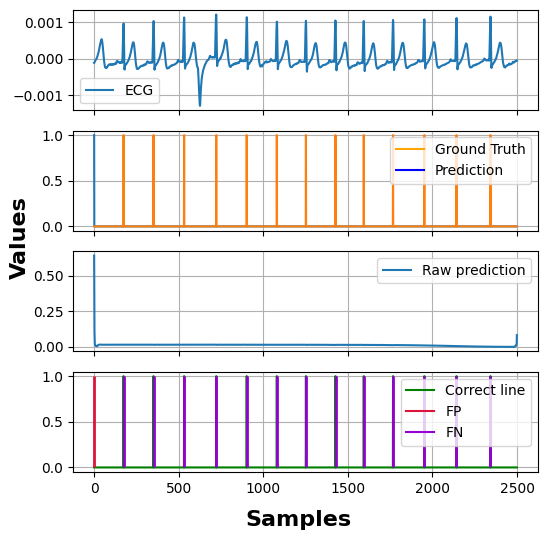

 14%|█▍        | 65/462 [00:33<03:37,  1.83it/s]

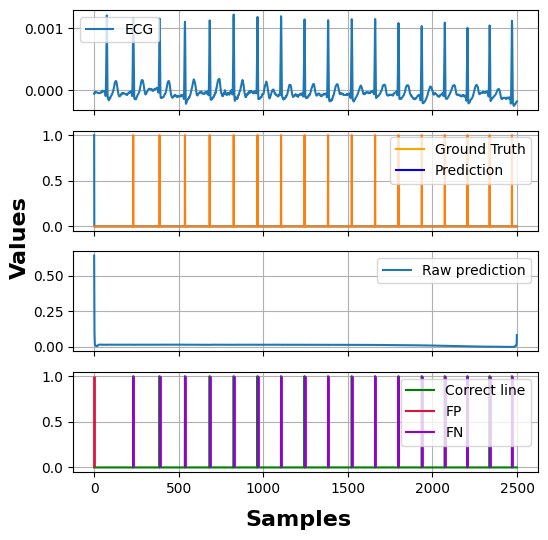

 14%|█▍        | 66/462 [00:34<03:27,  1.91it/s]

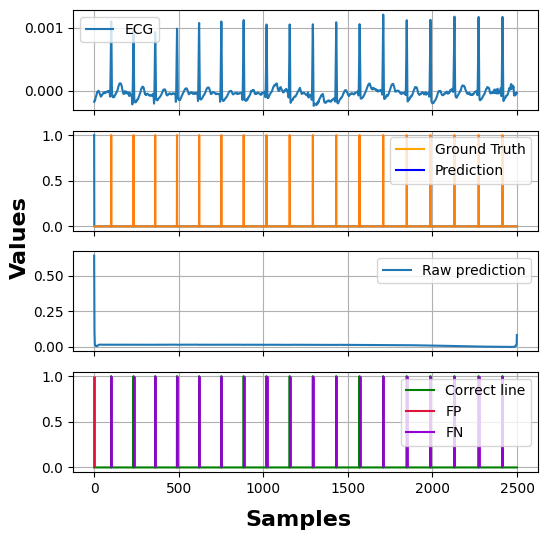

 15%|█▍        | 67/462 [00:34<03:20,  1.97it/s]

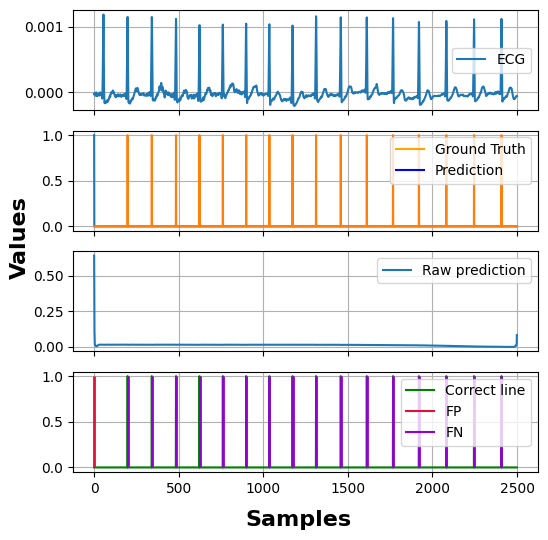

 15%|█▍        | 68/462 [00:35<03:20,  1.96it/s]

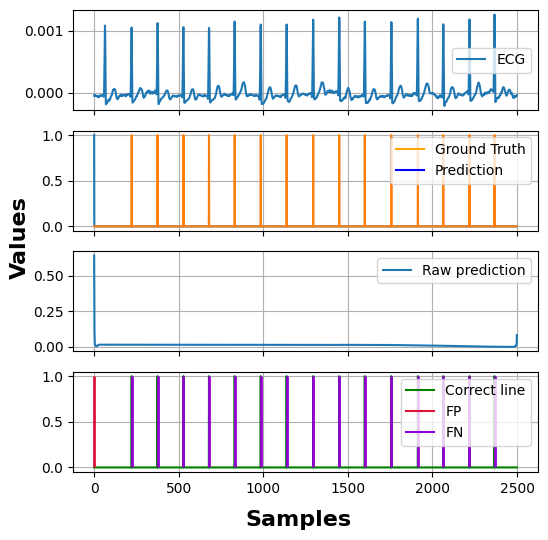

 15%|█▍        | 69/462 [00:35<03:15,  2.01it/s]

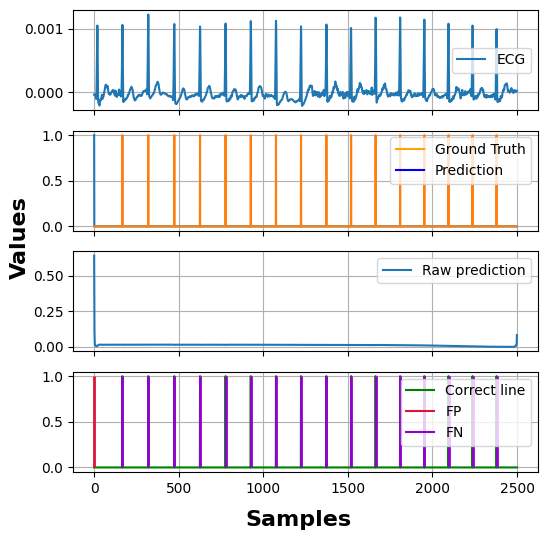

 15%|█▌        | 70/462 [00:36<03:11,  2.05it/s]

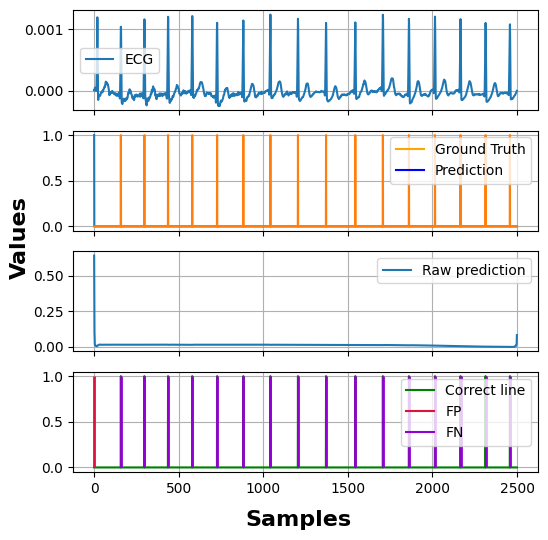

 15%|█▌        | 71/462 [00:36<03:09,  2.06it/s]

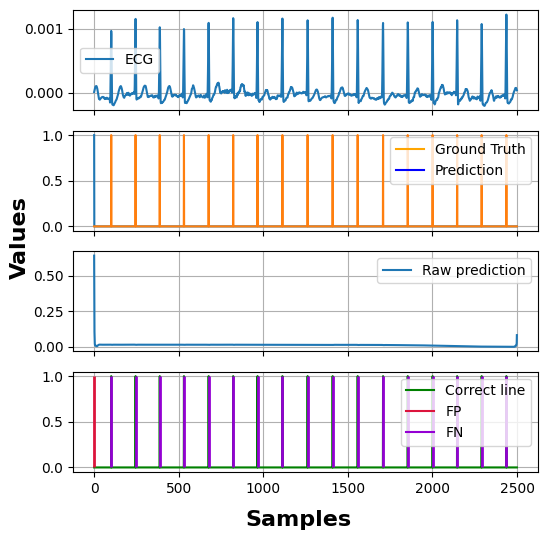

 16%|█▌        | 72/462 [00:37<03:10,  2.05it/s]

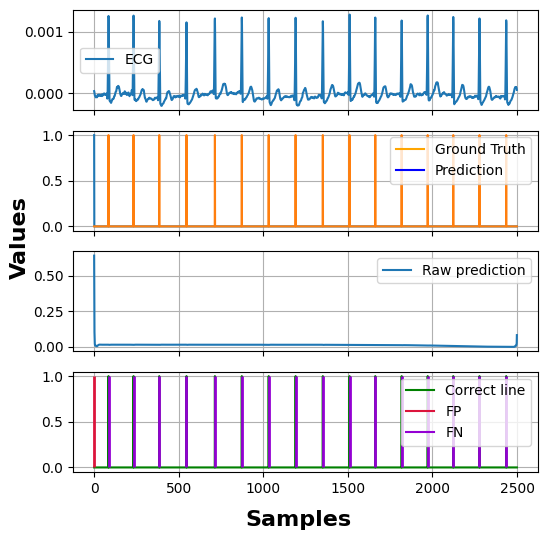

 16%|█▌        | 73/462 [00:37<03:32,  1.83it/s]

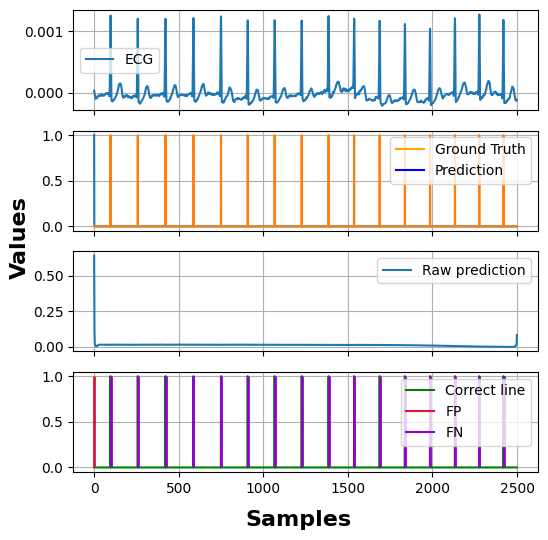

 16%|█▌        | 74/462 [00:38<03:23,  1.91it/s]

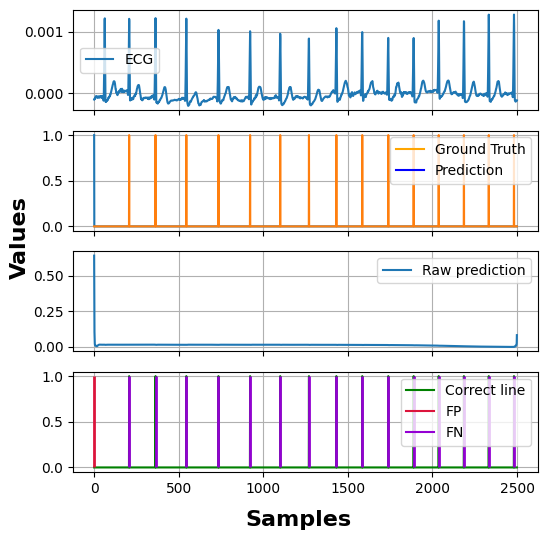

 16%|█▌        | 75/462 [00:38<03:15,  1.98it/s]

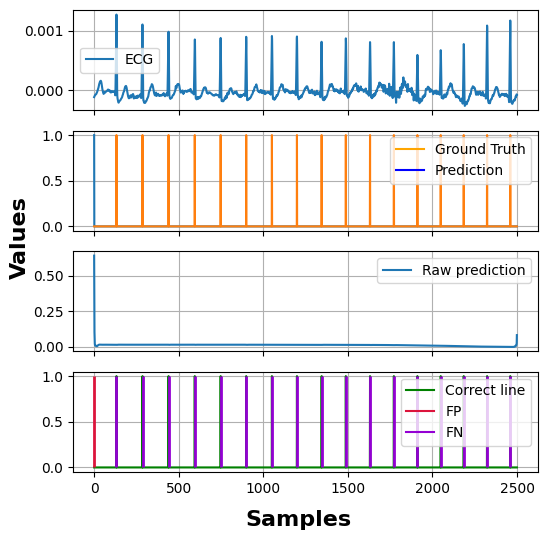

 16%|█▋        | 76/462 [00:39<03:10,  2.03it/s]

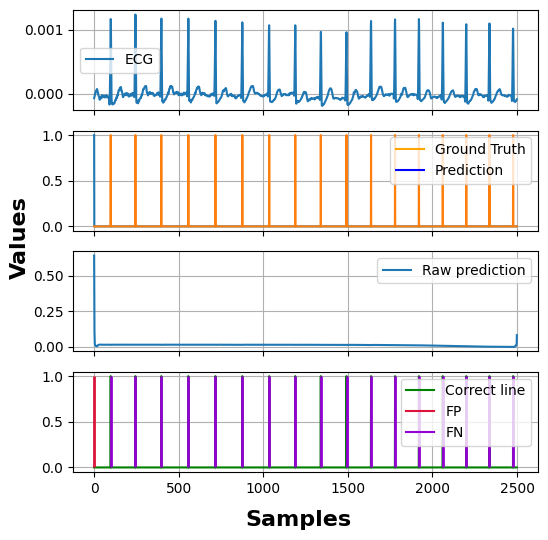

 17%|█▋        | 77/462 [00:39<03:06,  2.07it/s]

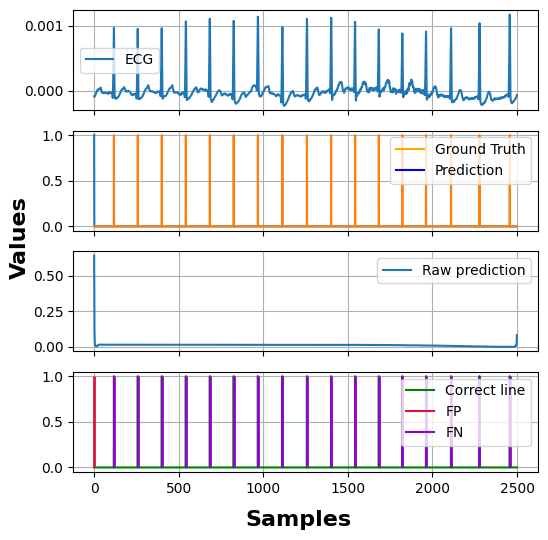

 17%|█▋        | 78/462 [00:40<03:04,  2.08it/s]

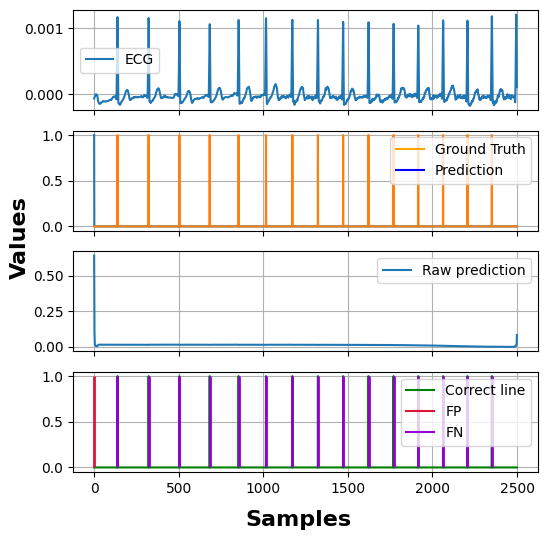

 17%|█▋        | 79/462 [00:40<03:06,  2.05it/s]

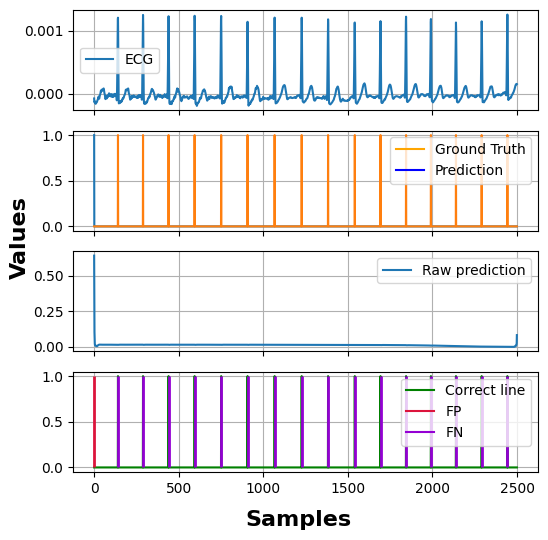

 17%|█▋        | 80/462 [00:41<03:03,  2.08it/s]

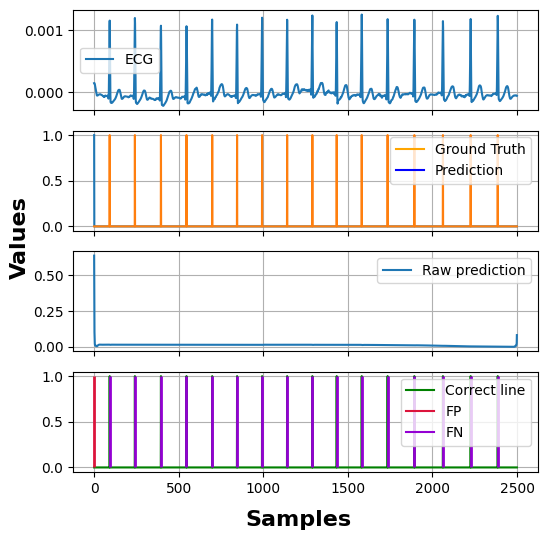

 18%|█▊        | 81/462 [00:41<03:23,  1.87it/s]

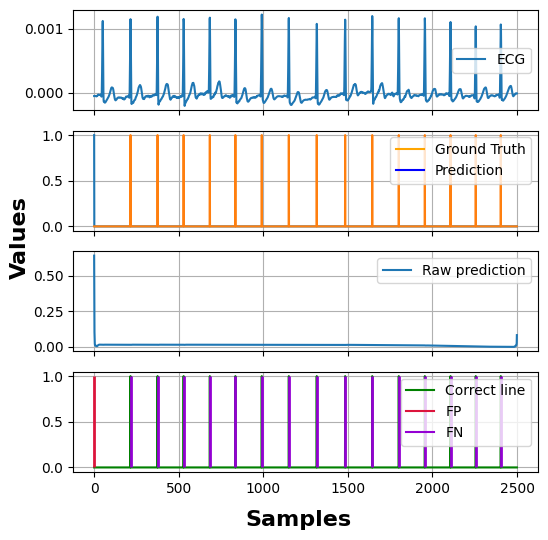

 18%|█▊        | 82/462 [00:42<03:18,  1.91it/s]

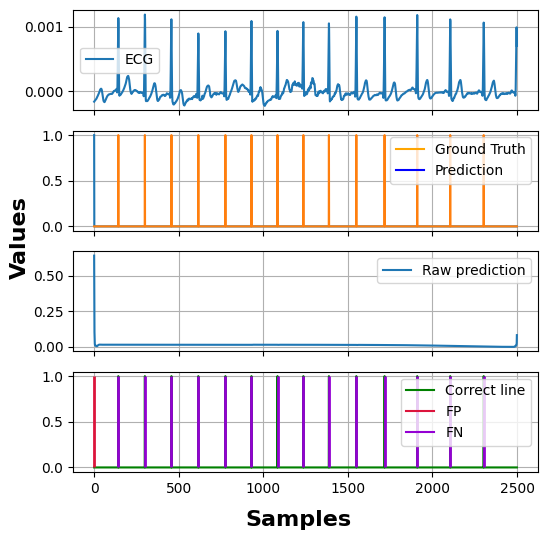

 18%|█▊        | 83/462 [00:42<03:11,  1.98it/s]

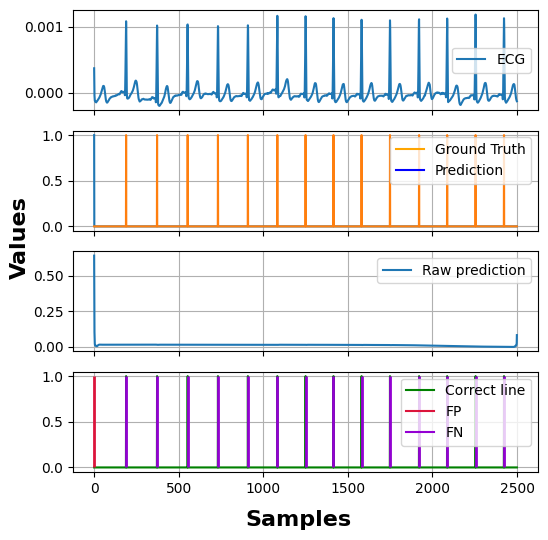

 18%|█▊        | 84/462 [00:43<03:05,  2.03it/s]

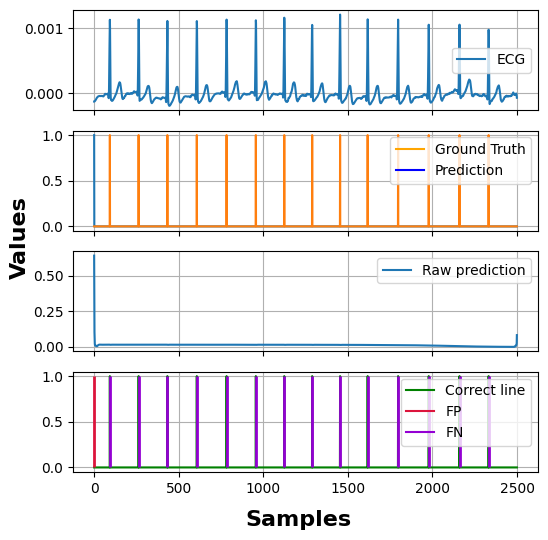

 18%|█▊        | 85/462 [00:43<03:06,  2.02it/s]

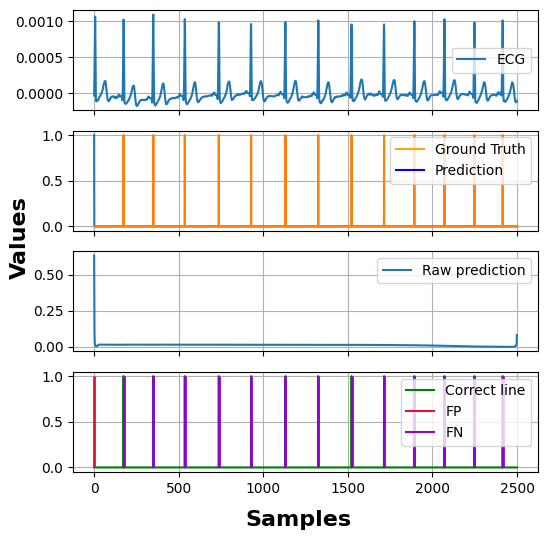

 19%|█▊        | 86/462 [00:44<03:02,  2.06it/s]

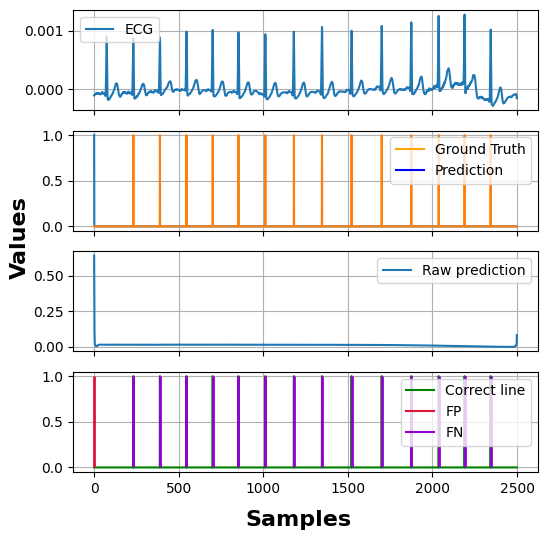

 19%|█▉        | 87/462 [00:44<02:59,  2.09it/s]

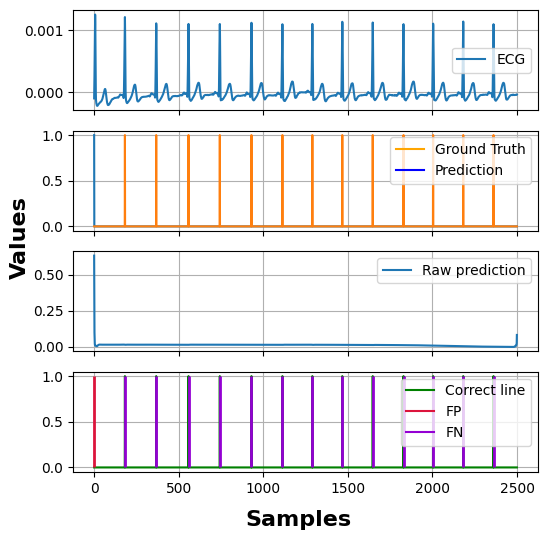

 19%|█▉        | 88/462 [00:45<03:04,  2.02it/s]

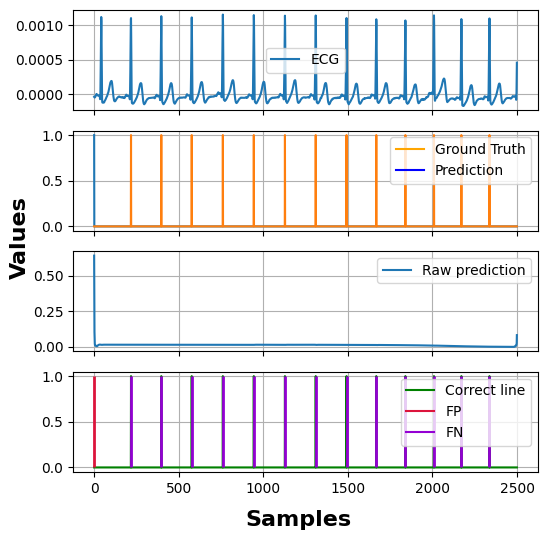

 19%|█▉        | 89/462 [00:45<03:04,  2.02it/s]

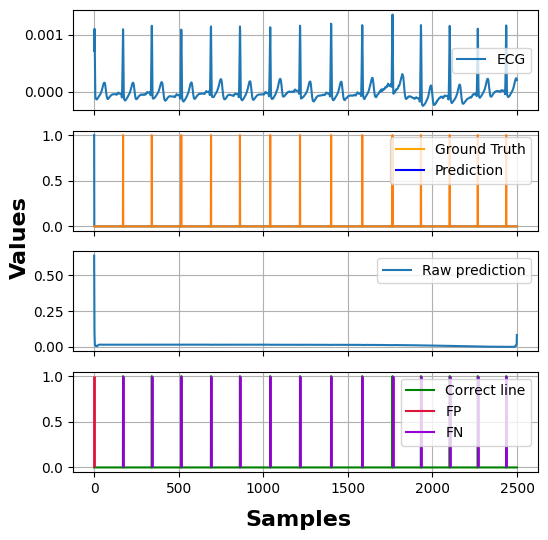

 19%|█▉        | 90/462 [00:46<03:34,  1.73it/s]

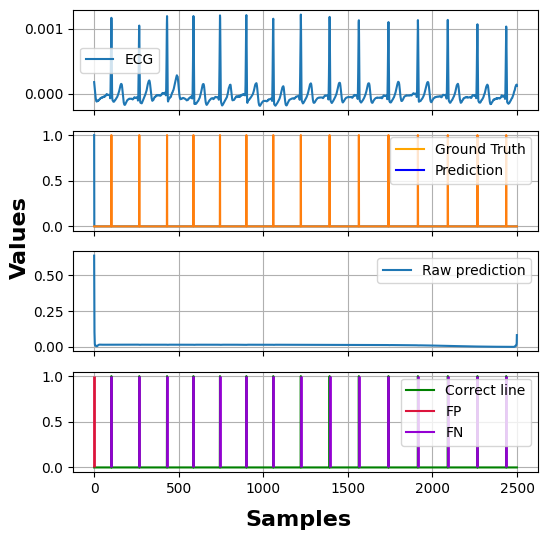

 20%|█▉        | 91/462 [00:47<03:14,  1.91it/s]


KeyboardInterrupt: 

In [17]:
test_model(raw_lstm, x_aidmed_raw, y_aidmed_raw, True)